# Identifying High Growth Zipcodes for Property Investment

## Background

*Investate* are a US-based start-up focused on the acquisition of residential properties in up-and-coming areas.  

They consistently follow a three-step strategy:
1. Purchase well-maintained properties in area with high growth potential
2. Let property, ideally on long-term lease
3. Sell tenanted-properties by year 5 to realise capital gains

Following a recent funding round, *Investate* have raised $100 million.  To ensure that this money is invested wisely, we have been appointed to **identify the top 5 best zipcodes in which to invest**. 

## The Dataset

To investigate this problem, data has been sourced from *Zillow*.  *Zillow* is the leading real estate and rental marketplace in the US.  It maintains a database of 110 million properties across the country.  From this, they are able to provide zipcode-level sales and rental price history dating back to 1996.  

## The Approach

To provide recommendations to Zillow, the following approach has been employed:
- The data is imported and pre-processed to remove missing values and identify outliers
- Exploratory data analysis is performed to identify:
    - high growth states
    - high growth counties within the high growth states
- Data for selected counties is extracted
- Each county dataset is split into a training and test set
- Each dataset is assessed for evidence of stationarity, seasonality and autocorrelation.  This assists with model selection
- Alternative models compared.  Model with best performance is selected
- Predictions are run to calculate growth
- Zipcodes with highest forecast growth, and excellent model performance are identified as investable

## The Criteria

*Investate* consider are looking to take a balanced approach to risk and return.  In practice, this means that each of the 5 zipcodes recommended must meet the following criteria:
- Forecast growth of at least 35% across a 5 year period
- Be situated in at least 2 geographically distinct areas.  This will help to balance portfolio diversity with the logistical challenge associated with managing properties in different areas


## Step 0a: Import the Libraries Required

Before getting started, all libraries required to complete the investigation are imported.

In [1]:
!pip install folium

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
import folium
from ast import literal_eval
import warnings
warnings.filterwarnings("ignore")

## Step 0b: Set Pandas Display Settings and Visualisation Scheme

To ensure that data can be properly inspected, the Pandas display settings are changed so that:
- A maximum of 2000 rows are displayed
- A maximum of 500 columns are displayed

In [3]:
# Set max rows to display to 2000
pd.set_option('display.max_rows', 2000)
# Set max columns to display to 500
pd.set_option('display.max_columns', 500)

The scheme for all charts/graphs is set in advance.  

In [4]:
# Define color palette
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
CB91_BlueD = '#016794'
CB91_GreenD = '#187970'
CB91_PinkD = '#B317B1'
CB91_PurpleD = '#4E1762'
CB91_VioletD = '#330E4C'
CB91_AmberD = '#985E09'
CB91_BlueL = '#D5F2FF'
CB91_GreenL = '#DAF8F5'
CB91_PinkL = '#FDECFC'
CB91_PurpleL = '#9D2EC5'
CB91_VioletL = '#ECD4F5'
CB91_AmberL = '#E2C8F4'

#A list that we’ll use to cycle through colors in charts
color_list = [CB91_Blue, CB91_Green, CB91_Amber, CB91_Pink, CB91_Violet, CB91_BlueD,
             CB91_GreenD, CB91_Purple, CB91_BlueL, CB91_GreenL, CB91_AmberL,
             CB91_PinkL, CB91_VioletL, CB91_AmberD, CB91_PinkD, CB91_VioletD]

#Use seaborn to set all the default chart visual settings
sns.set(font='Franklin Gothic Book',
       rc={'axes.axisbelow': False,
           'axes.edgecolor': 'lightgrey',
           'axes.facecolor': 'white',
           'axes.grid': False,
           'axes.labelcolor': 'dimgrey',
           'axes.spines.right': False,
           'axes.spines.top': False,
           'figure.facecolor': 'white',
           'lines.solid_capstyle': 'round',
           'patch.edgecolor': 'w',
           'patch.force_edgecolor': True,
           'text.color': 'dimgrey',
           'xtick.bottom': False,
           'xtick.color': 'dimgrey',
           'xtick.direction': 'out',
           'xtick.top': False,
           'ytick.color': 'dimgrey',
           'ytick.direction': 'out',
           'ytick.left': False,
           'ytick.right': False})

sns.set_context('paper', rc={'font.size':16,'axes.titlesize':19,'axes.labelsize':16})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)



# Step 0b: Define Useful Functions

To prevent the need for repetition of code, the following functions have been defined:
- **melt_data(df)**: Reshapes zipcode data from wide to long format<br><br>
- **county_growth(state)**: Calculate house price growth in each county, for a given state<br><br>
- **county_visual(state_data,name)**: Create a horizontal bar chart displaying growth 1998/2008 and 2008/2018 by county<br><br>
- **train_test_split(data)**: Create a train/test split for each zipcode<br><br>
- **check_stationarity(df, zipcode)**: Checks for stationarity by plotting the rolling mean/standard deviation and applying the Dickey-Fuller Test<br><br>
- **check_seasonality(df)**: Decomposes a time series into trend, seasonality and white noise<br><br>
- **check_autocorrelation(df,lags,col)**: Plot the autocorrelation and partial autocorrelation functions for a given dataset and number of lags<br><br>
- **optimise_sarimax(df, p, d, q)**: Identifies the optimal number of lagged dependent variables (p), difference (d) and lagged residuals (q) to include in a SARIMA model<br><br>
- **make_predictions(model, date, df, position)**: Charts a model's predictions against actual values<br><br>

In [5]:
# Reshape data from wide to long
def melt_data(df):
    # Use melt function to reshape with date as index, identifier variables set as id_vars
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'NumberMissingValues'], var_name='time')
    # Set time to datetime format to facilitate timeseries analysis
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    # Return reshaped dataset with timeseries as index value, and mean house price
    return melted.groupby('time').aggregate({'value':'mean'})

In [6]:
def county_growth(state):
    data = df[df['State']==state]
    data = data.groupby(by='CountyName', axis=0).mean()
    data.reset_index(inplace=True)
    data['Growth2008to2018'] = ((data['2018-04']-data['2008-01'])/data['2008-01'])*100
    data['Growth1998to2008'] = ((data['2008-01']-data['1998-01'])/data['1998-01'])*100
    data.sort_values(by=['Growth2008to2018'], ascending=False, inplace=True)
    return data

In [7]:
def county_visual(state_data, name):
    growth = state_data[['CountyName', 'Growth1998to2008', 'Growth2008to2018']]
    growth.set_index('CountyName', inplace=True)
    growth.plot.barh(figsize=(20,15), width=0.8)
    plt.title(f"{name}: Growth by County (%) 1998 to 2008 v. 2008 to 2018")
    plt.ylabel('County', fontsize=30)
    plt.xlabel('Growth(%)')
    plt.show()


In [8]:
def train_test_split(data):
    
    train = []
    test = []
    
    for i in range(0, len(data)):
    #Split datasets into training and testing
        train_df = data[i].iloc[:training_n]
        test_df = data[i].iloc[training_n:]
    
    #Append training and test datasets to list
        train.append(train_df)
        test.append(test_df)
    return train, test
    

In [9]:
# Assess stationarity of time series
def check_stationarity(df, zipcode):
    
    # Calculate rolling mean and standard deviation using a 12 month window
    rolmean = df.rolling(window=12, center=False).mean()
    rolstd = df.rolling(window=12, center=False).std()
    
    # Plot rolling mean and standard deviation against the original time series data
    fig = plt.figure(figsize=(14,7))
    original = plt.plot(df, label='Original')
    mean = plt.plot(rolmean, label = 'Rolling Mean')
    std = plt.plot(rolstd, label = 'Rolling Standard Deviation')
    plt.title(f"Staionarity Check for Zipcode {zipcode}")
    plt.legend()
    plt.show(block=False)
    
    # Conduct a Dickey-Fuller test on time series to provide a statistical measure of stationarity
    dftest = adfuller(df['value'])
    
    # Create an easy-to-read series with key Dickey-Fuller parameters
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print('Results of Dickey-Fuller Test')
    print(dfoutput)

In [10]:
# Assess seasonality of data 
def check_seasonality(df, col):
    # Use Statsmodels seasonal_decompose function to split time series variation into trend, seasonal variation and white noise
    result = seasonal_decompose(df)
    # Plot Trend, Seasonal and Residual on 3 consecutive axes
    result.trend.plot(ax=axes[0][col])
    axes[0][col].set_ylabel('Trend')
    result.seasonal.plot(ax=axes[1][col])
    axes[1][col].set_ylabel('Seasonal')
    result.resid.plot(ax=axes[2][col])
    axes[2][col].set_ylabel('Residual')
    

In [11]:
# Plot the autocorrelation and partial autocorrelation functions for a given dataset and number of lags
def check_autocorrelation(df, lags, col):
    plot_acf(df, lags=lags, ax=ax[0][col])
    plot_pacf(df, lags=lags, ax=ax[1][col])

In [12]:
# Identify optimal order of SARIMAX function.  p, d, and q represent maximum values
def optimise_sarimax(df, p, d, q):
    
    # Create a list with all possible values for p, d and q up to specified maximum
    p = list(range(0,p))
    d = list(range(0,d))
    q = list(range(0,q))


    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency given annual cyclicality)
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    
    # Create dataframe that displays order v. AIC criterion.  Order with lowest AIC selected
    results = []

    for i in range(0, len(pdqs)):
        model = sm.tsa.statespace.SARIMAX(endog=df, order = pdq[i], seasonal_order = pdqs[i], enforce_stationarity = False, enforce_invertibility = False, freq='MS')
        result = model.fit(maxiter=200)
        results.append({'pdq': f"{pdq[i]}", 'pdqs': f"{pdqs[i]}", 'AIC':result.aic})
    
    results_df = pd.DataFrame(results)
    results_df.sort_values(by=['AIC'], ascending = True, inplace=True)
    
    return results_df

In [13]:
# Charts a model's predictions against actual values
def make_predictions(model, date, df, position):
    
    fig.add_subplot(position)
    
    pred = model.get_prediction(start=pd.to_datetime(date), dynamic=False)
    pred_conf = pred.conf_int()
    
    
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    df['2007':].plot(label='observed', ax=ax)

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('House Price')
  

    plt.show()


# Step 1: Load the Data

The sales price dataset has been made available in CSV format.  This is loaded using Pandas.

In [14]:
# Load the dataset
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

It is notable that the dataset is in a wide format (i.e. dates are given in columns, not rows).  This facilitates easy data exploration.  However, it will need to be reformatted in order to build time series models.

# Step 2: Data Preprocessing

A clean dataset provides the foundation for a good statistical model.  Therefore, before proceeding, the following tasks are completed:
- Missing values are identified and managed
- Outliers are identified and dealt with

## Identify Missing Values

To identify missing values, a new column is created which gives the number of missing values for each zipcode.

In [15]:
cols = list(df.columns[7:])
df['NumberMissingValues'] = df[cols].isna().sum(axis=1)

Next, the typical number of missing values for a zipcode was assessed.

In [16]:
df['NumberMissingValues'].value_counts()

0      13684
167      230
87       118
111       78
117       56
219       56
201       55
213       53
105       52
207       42
171       41
177       33
93        31
123       27
189       27
183       24
99        21
129       20
195       18
107       13
153       11
147        9
159        7
135        7
141        6
21         2
15         1
165        1
Name: NumberMissingValues, dtype: int64

As can be seen from the above, the majority of zipcodes (13,684) do not have any missing data.  The remaining zipcodes typically have many missing values (around 100-220).  Given that observations are monthly, 12 observations represent 1 year of data, whilst 120 observations represent 10 years of data.  

A decision is taken that any zipcode with more than 2 years worth of missing data (24 observations) will be dropped.

In [17]:
# Create dataframe with all observations with more than 24 missing values
missingvalues = df[df['NumberMissingValues']>24].sort_values(['NumberMissingValues'], ascending=False)
# Identify the index numbers for all observations with more than 24 missing values
missingobs = missingvalues.index
# Drop missing values if more than 2 years' worth observations are missing
df.drop(index=missingobs, inplace=True)

Now, identify any remaining zipcodes with missing data:

In [18]:
df[df['NumberMissingValues']>0]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,NumberMissingValues
9906,67592,23192,Montpelier,VA,Richmond,Hanover,9907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95900.0,100900.0,105600.0,110300.0,115000.0,119500.0,123800.0,127800.0,131500.0,134900.0,138100.0,141400.0,144800.0,147700.0,149700.0,151700.0,153400.0,155000.0,156400.0,157500.0,158300.0,159200.0,160000.0,161100.0,162500.0,163700.0,164300.0,165000.0,165700.0,166400.0,167000.0,167400.0,167900.0,168400.0,168900.0,169700.0,170800.0,171900.0,172700.0,173600.0,174600.0,175600.0,176600.0,177400.0,178300.0,179300.0,180300.0,181500.0,182800.0,184200.0,185800.0,187400.0,189000.0,190600.0,192100.0,193400.0,194700.0,195900.0,197500.0,199500.0,201100.0,201900.0,202300.0,202200.0,201900.0,201500.0,201400.0,201500.0,201800.0,202500.0,203200.0,204100.0,205500.0,207800.0,210800.0,214100.0,217200.0,220400.0,223500.0,226500.0,229100.0,231500.0,233700.0,236100.0,238600.0,241200.0,243900.0,247000.0,250300.0,253700.0,257200.0,261200.0,265700.0,270500.0,274900.0,278600.0,281600.0,284000.0,286600.0,289400.0,292200.0,294900.0,297600.0,300000.0,301700.0,303000.0,303800.0,304100.0,303800.0,302600.0,301300.0,300100.0,298800.0,297300.0,295800.0,294200.0,292300.0,290200.0,288300.0,286900.0,285800.0,285300.0,285500.0,286100.0,286100.0,285000.0,283100.0,280900.0,278200.0,275400.0,272700.0,270300.0,267900.0,265700.0,264200.0,263100.0,261800.0,259800.0,257700.0,256000.0,254500.0,253500.0,253200.0,253300.0,253200.0,254000.0,252200.0,247900.0,244500.0,242700.0,240300.0,238200.0,237600.0,238700.0,239300.0,238000.0,235900.0,233300.0,231400.0,230400.0,229200.0,229000.0,229600.0,229100.0,228100.0,227000.0,226100.0,226700.0,228000.0,228000.0,227200.0,225700.0,224900.0,224500.0,225000.0,225700.0,226600.0,226000.0,224700.0,223800.0,224200.0,224500.0,225300.0,227100.0,229000.0,2

There are only 3 observations, all based in Richmond, Virginia.  This missing data is from the period 1996 to 1997/8.  Given the age and brevity of the missing data, it will be dealt with by back-filling the missing values with the nearest available house price data for the zipcode.

In [19]:
idx = [9906,11332,13504]
value = [95900.0, 85000.0, 103500.0]

for i in range(0,len(idx)):
    for j in range(0, len(cols)):
        if np.isnan(df.loc[idx[i], cols[j]]) == True:
            df.loc[idx[i], cols[j]] = value[i]
            

All missing values have now been dealt with.  

## Step 3: EDA and Visualization

### Visualise Growth by State on a Map

To provide a high level overview of house price growth in the USA, two maps have been created showing the distribution of house price growth across states in over the period **1998 to 2008** and **2008 to 2018**.

In order to create the maps, a dataframe giving average monthly house price, and growth across the two periods specified, by state is created.  

In [20]:
# Create dataframes which groups mean house price values by state
state = df.groupby(['State']).mean()
# Drop the columns which are surplus to requirement
state.drop(['RegionID', 'RegionName', 'SizeRank','NumberMissingValues'], axis=1, inplace=True)
# Reset the index
state.reset_index(inplace=True)
# Compute % growth across the two specified periods
state['Growth 2008 to 2018'] = ((state['2018-04'] - state['2008-01'])/state['2008-01'])*100
state['Growth 1998 to 2008'] = ((state['2008-01'] - state['1998-01'])/state['1998-01'])*100

The top 5 states by growth in house prices 2008 to 2018 are shown.

In [21]:
# Display top 5 states by mean house price growth 2008 to 2018
state.sort_values(by=['Growth 2008 to 2018'], ascending=False)[0:5]

,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Growth 2008 to 2018,Growth 1998 to 2008
5,CO,142561.943320,142765.991903,142985.425101,143204.453441,143461.943320,143752.631579,144106.882591,144507.287449,145057.085020,145729.149798,146382.591093,146967.611336,147608.097166,148289.878543,149005.263158,149753.441296,150531.983806,151343.724696,152185.829960,153072.874494,154108.097166,155254.655870,156369.230769,157434.412955,158574.898785,159761.943320,161014.574899,162327.125506,163694.736842,165105.668016,166597.165992,168154.655870,169896.356275,171749.392713,173569.230769,175342.914980,177171.659919,178986.639676,180817.813765,182660.323887,184517.813765,186381.376518,188291.902834,190263.562753,192408.502024,194664.372470,196893.927126,199036.437247,201175.708502,203265.182186,205305.668016,207295.141700,209238.056680,211121.457490,212981.376518,214837.651822,216739.271255,218651.012146,220473.279352,222189.068826,223788.663968,225222.267206,226507.287449,227650.202429,228664.372470,229573.279352,230419.433198,231239.676113,232053.036437,232878.947368,233699.190283,234453.441296,235087.854251,235591.093117,235991.093117,236302.429150,236550.607287,236791.497976,237073.684211,237371.255061,237592.712551,237742.510121,237912.145749,238165.587045,238478.542510,238835.627530,239246.558704,239711.336032,240232.388664,240859.109312,241583.400810,242311.336032,242993.522267,243633.198381,244222.672065,244793.522267,245432.388664,246214.574899,247172.469636,248274.898785,249453.036437,250706.882591,252049.797571,253446.558704,254942.510121,256472.064777,257924.696356,259370.040486,260917.004049,262501.619433,264168.825911,265946.558704,267782.995951,269644.939271,271483.805668,273259.919028,275002.834008,276710.526316,278325.506073,280021.052632,281820.242915,283535.627530,285103.643725,286625.101215,288049.797571,289387.449393,290668.825911,291889.068826,293138.056680,294412.145749,295497.5

To create a map of house price growth, the **folium** function choropleth() is used.  This overlays a map with shading, which varies according to a specified metric (in this case, house price growth).

In order to create the choropleth, a json file containing the shape of each state was used.  This was sourced from a public <a href =https://raw.githubusercontent.com/python-visualization/folium/master/tests/us-states.json>Github respository</a> and saved as *'states.json'*.

### House Price Growth: 1998 to 2008

In [22]:
# First, a map object is created using the coordinates for the USA
map1998to2008 = folium.Map(location=[48, -102], zoom_start=3)
# Next, a choropleth is overlaid.  This shades each state according to the level of house price growth 1998 to 2008
map1998to2008.choropleth(geo_data='states.json', data=state, columns=['State', 'Growth 1998 to 2008'], 
               key_on='feature.id', fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, 
               legend_name='Mean House Price Growth(%)')
# The map object is displayed
map1998to2008

### House Price Growth: 2008 to 2018

In [23]:
# First, a map object is created using the coordinates for the USA
map2008to2018 = folium.Map(location=[48, -102], zoom_start=3)
# Next, a choropleth is overlaid.  This shades each state according to the level of house price growth 2008 to 2018
map2008to2018.choropleth(geo_data='states.json', data=state, columns=['State', 'Growth 2008 to 2018'], 
               key_on='feature.id', fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, 
               legend_name='Mean House Price Growth(%)')
# The map object is displayed
map2008to2018

Comparing these two maps, the following is notable:
- The scale on the 1998-2008 map is much greater than the scale on the 2008-2018 map.  This is likely due to the US house price bubble, which burst around 2006/7:<br><br>
    - 1998-2008 mean house price growth ranged from 35% to 204%
    - 2008-1998 mean house price growth ranged from -14% to 39% <br><br>
- Colorado & California displayed strong house price growth in both periods (relative to other states).<br><br>
- Sothern states such as Texas appeared to exhibit relatively stronger house price growth.<br><br>

### Visualise Trends for Top 2 Areas

Given that *Investate* is looking to invest in 2 geographically distinct, high growth areas, trends in house price performance in the top 2 areas are visualised.

In [24]:
# Sort the state dataframe by growth 2008-18, and display highest performing states
state.sort_values(by=['Growth 2008 to 2018'], ascending=False)[0:5]

,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Growth 2008 to 2018,Growth 1998 to 2008
5,CO,142561.943320,142765.991903,142985.425101,143204.453441,143461.943320,143752.631579,144106.882591,144507.287449,145057.085020,145729.149798,146382.591093,146967.611336,147608.097166,148289.878543,149005.263158,149753.441296,150531.983806,151343.724696,152185.829960,153072.874494,154108.097166,155254.655870,156369.230769,157434.412955,158574.898785,159761.943320,161014.574899,162327.125506,163694.736842,165105.668016,166597.165992,168154.655870,169896.356275,171749.392713,173569.230769,175342.914980,177171.659919,178986.639676,180817.813765,182660.323887,184517.813765,186381.376518,188291.902834,190263.562753,192408.502024,194664.372470,196893.927126,199036.437247,201175.708502,203265.182186,205305.668016,207295.141700,209238.056680,211121.457490,212981.376518,214837.651822,216739.271255,218651.012146,220473.279352,222189.068826,223788.663968,225222.267206,226507.287449,227650.202429,228664.372470,229573.279352,230419.433198,231239.676113,232053.036437,232878.947368,233699.190283,234453.441296,235087.854251,235591.093117,235991.093117,236302.429150,236550.607287,236791.497976,237073.684211,237371.255061,237592.712551,237742.510121,237912.145749,238165.587045,238478.542510,238835.627530,239246.558704,239711.336032,240232.388664,240859.109312,241583.400810,242311.336032,242993.522267,243633.198381,244222.672065,244793.522267,245432.388664,246214.574899,247172.469636,248274.898785,249453.036437,250706.882591,252049.797571,253446.558704,254942.510121,256472.064777,257924.696356,259370.040486,260917.004049,262501.619433,264168.825911,265946.558704,267782.995951,269644.939271,271483.805668,273259.919028,275002.834008,276710.526316,278325.506073,280021.052632,281820.242915,283535.627530,285103.643725,286625.101215,288049.797571,289387.449393,290668.825911,291889.068826,293138.056680,294412.145749,295497.5

As can be seen, the three fastest growing areas are:
- Colorado
- Washington DC (NB: This is a city, not a state)
- California

However, since Washington DC is not a state, Colorado and California will be selected for further analysis.  

To visualise this data, three distinct dataframes, representing each area is created. 

In [25]:
# Define a function that extracts the data for the particular state, and makes it into a time series
def state_data(state_code):
    df = state[state['State'] == state_code]
    df = pd.melt(df, id_vars = ['State'], var_name='Date', value_name=state_code)
    df.drop(['State'], axis=1, inplace=True)
    df.drop(index=[265,266],inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
    df.set_index('Date', inplace=True)
    return df

In [26]:
# Create three distinct dataframes, one for each area
CA = state_data('CA')
CO = state_data('CO')

Finally, the timeseries showing monthly mean house price for each area is plotted.  

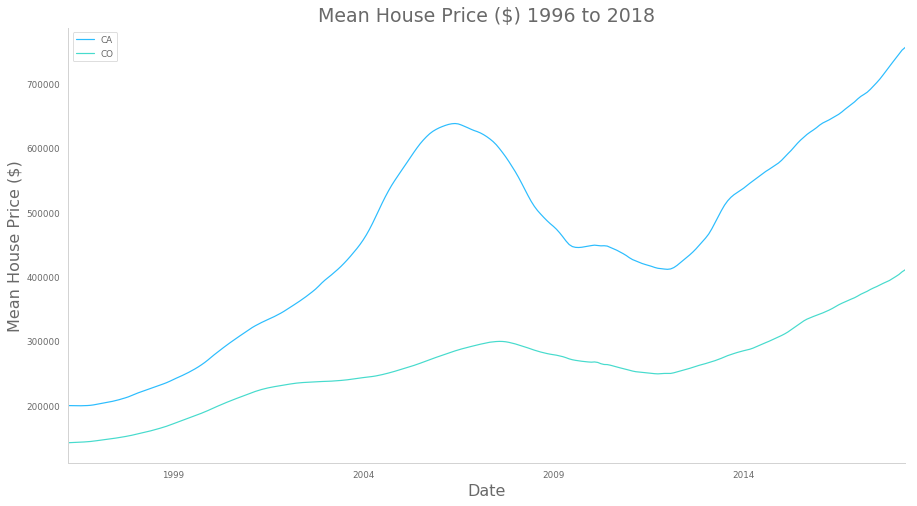

In [27]:
ax = CA.plot(label='California', figsize=(15,8))
CO.plot(ax=ax, label='Colorado')
plt.legend()
plt.title('Mean House Price ($) 1996 to 2018')
plt.ylabel('Mean House Price ($)')
plt.show()

As can be seen from the above:
- House prices in California are typically higher than Colorado.
- Colorado has exhibited fairly consistent growth across the period.  
- Growth in  California has been more volatile, which a notable downswing around 2006/7.  However, from 2011/12 there has ben rapid growth.  

### Visualise House Price Growth by County: Colorado

We will now drill into county-level house price growth by comparing two periods for each state:
- 1998 to 2008 (covers the US housing bubble)
- 2008 to 2018 (covers post-recession, recent house price activity)

First, Colorado.

In [28]:
# Apply county_growth() function to generate mean monthly house price by state
colorado = county_growth('CO')
colorado.head()

,CountyName,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,NumberMissingValues,Growth2008to2018,Growth1998to2008
0,Adams,93311.200000,80240.200000,4170.533333,123260.000000,123593.333333,123953.333333,124320.000000,124726.666667,125140.000000,125593.333333,126086.666667,126686.666667,127393.333333,128026.666667,128560.000000,129140.000000,129706.666667,130300.000000,130913.333333,131546.666667,132186.666667,132813.333333,133480.000000,134260.000000,135106.666667,135893.333333,136613.333333,137413.333333,138260.000000,139200.000000,140213.333333,141300.000000,142440.000000,143640.000000,144920.000000,146353.333333,147873.333333,149413.333333,150913.333333,152500.000000,154133.333333,155800.000000,157520.000000,159246.666667,161000.000000,162780.000000,164626.666667,166660.000000,168780.000000,170920.000000,173020.000000,175180.000000,177366.666667,179526.666667,181646.666667,183720.000000,185726.666667,187680.000000,189586.666667,191480.000000,193326.666667,194993.333333,196573.333333,198040.000000,199353.333333,200546.666667,201633.333333,202600.000000,203486.666667,204360.000000,205213.333333,206053.333333,206920.000000,207746.666667,208533.333333,209253.333333,209913.333333,210493.333333,211033.333333,211486.666667,211913.333333,212353.333333,212653.333333,212786.666667,212853.333333,212946.666667,212886.666667,212773.333333,212580.000000,212380.000000,212253.333333,212166.666667,212240.000000,212440.000000,212706.666667,213033.333333,213373.333333,213726.666667,214100.000000,214500.000000,214840.000000,215133.333333,215373.333333,215606.666667,215940.000000,216460.000000,217113.333333,217933.333333,218686.666667,219220.000000,219573.333333,219866.666667,220166.666667,220586.666667,221086.666667,221560.000000,221873.333333,221960.000000,221893.333333,221693.333333,221460.000000,221213.333333,221100.000000,221006.666667,220860.000000,220586.666667,220260.000000,219

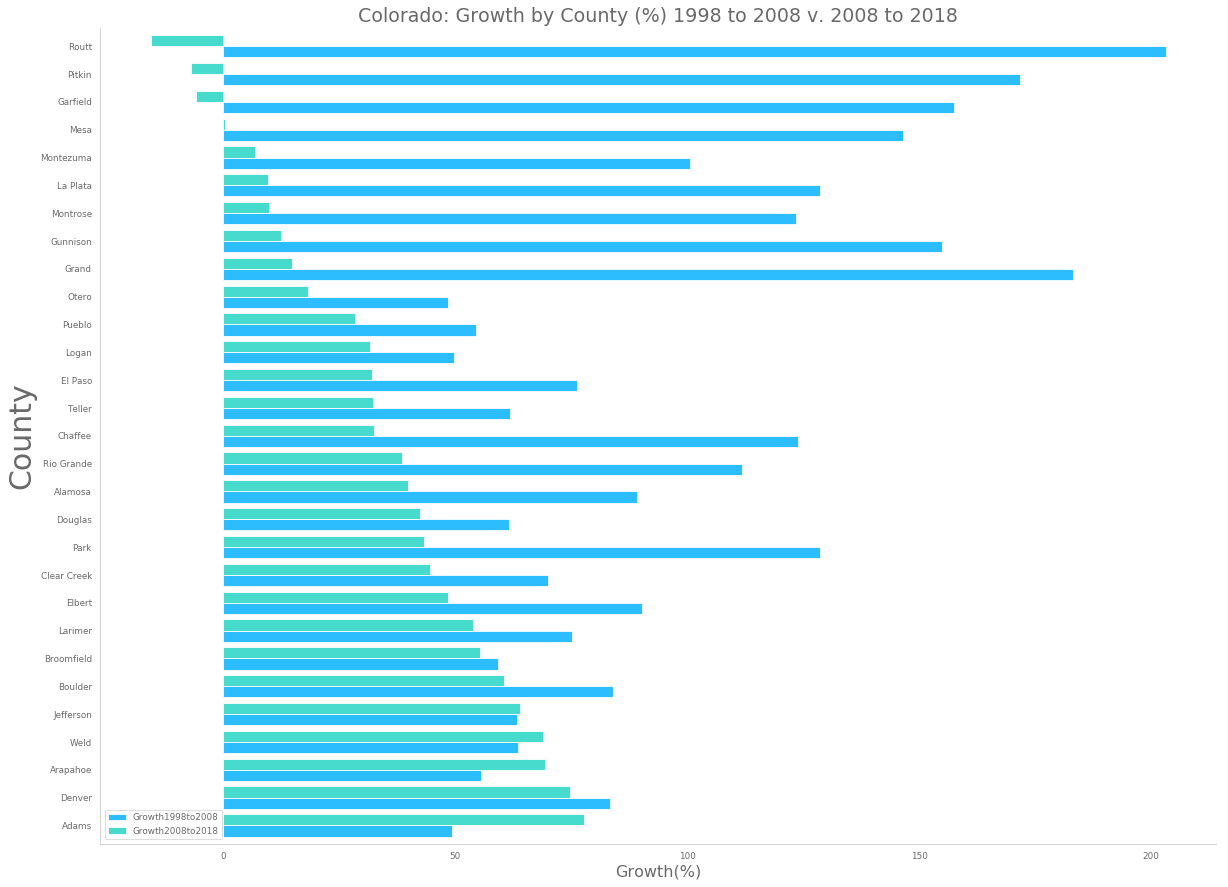

In [29]:
# Apply county_visual() function to generate horizontal bar chart comparing two periods by state
county_visual(colorado, 'Colorado')

This chart is striking for two reasons:
- Growth rates in the period 1998-2008 were significantly higher than 2008-2018 for almost all counties (bar Adams,  Arapahoe, Jefferson)
- It looks like the higher the growth rate in the period 1998-2008, the lower the growth rate in the period 2008-2018.  This suggests that counties hit hardest by the collapse of the housing bubble/recession, have failed to recover as quickly as those counties that did not have a have very rapid growth in the earlier decade.

### Visualise House Price Growth by County: California

Finally, house price growth in California is assessed.

In [30]:
# Apply county_growth() function to generate mean monthly house price by state
california = county_growth('CA')
california.head()

,CountyName,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,NumberMissingValues,Growth2008to2018,Growth1998to2008
39,Santa Clara,97886.865385,94875.596154,3730.038462,324865.384615,326401.923077,328015.384615,329728.846154,331542.307692,333513.461538,335750.000000,338203.846154,341280.769231,344901.923077,348653.846154,352421.153846,356607.692308,361094.230769,365840.384615,370736.538462,375634.615385,380453.846154,385221.153846,389792.307692,394513.461538,399282.692308,403611.538462,407388.461538,411080.769231,414601.923077,418007.692308,421301.923077,424457.692308,427546.153846,430698.076923,433894.230769,437615.384615,441890.384615,446450.000000,451269.230769,456936.538462,463473.076923,471038.461538,479730.769231,489442.307692,500178.846154,511976.923077,524626.923077,538476.923077,553075.000000,567676.923077,581953.846154,596123.076923,609700.000000,622530.769231,634394.230769,645011.538462,654198.076923,662090.384615,668488.461538,673546.153846,677450.000000,680000.000000,681084.615385,680938.461538,679811.538462,677994.230769,675638.461538,672990.384615,670409.615385,668178.846154,666286.538462,664988.461538,664713.461538,665498.076923,667048.076923,669167.307692,671817.307692,674890.384615,678153.846154,681298.076923,684317.307692,687048.076923,689950.000000,691911.538462,691973.076923,690578.846154,688944.230769,686821.153846,684792.307692,683476.923077,683348.076923,684526.923077,687234.615385,691382.692308,696807.692308,703640.384615,711744.230769,7.209000e+05,7.310981e+05,7.422865e+05,7.538904e+05,7.655923e+05,7.769962e+05,7.878596e+05,7.985538e+05,8.095135e+05,8.206577e+05,8.325788e+05,8.451269e+05,8.579308e+05,8.706404e+05,8.829077e+05,8.940442e+05,9.042212e+05,9.129481e+05,9.198365e+05,9.249865e+05,9.286500e+05,9.310865e+05,9.326212e+05,9.332365e+05,9.328462e+05,9.315750e+05,9.299962e+05,9.292058e+05,9.293135e+05,9.295654e+05,9.298154e+05,9.304846e+05,

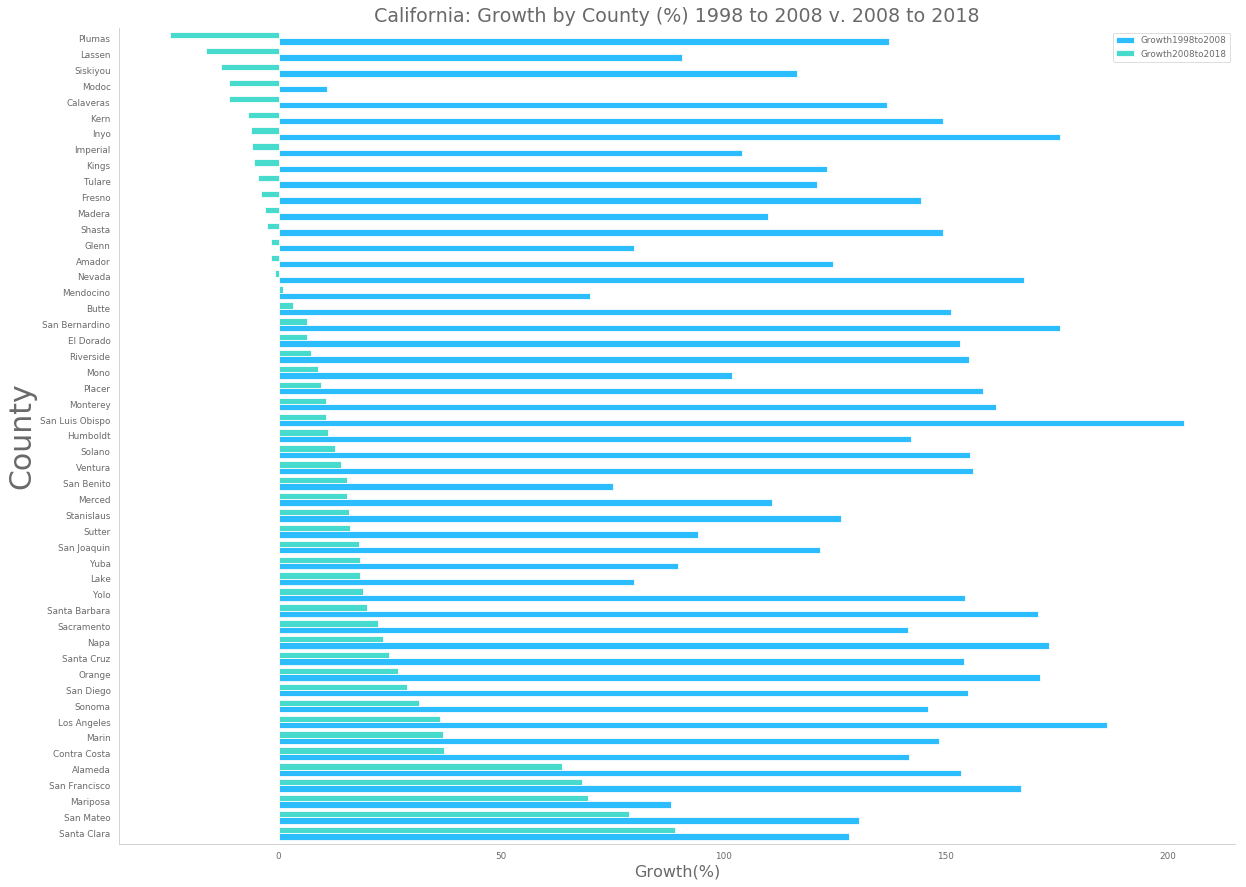

In [31]:
# Apply county_visual() function to generate horizontal bar chart comparing two periods by state
county_visual(california, 'California')

In every case, house price growth in California was significantly higher in the period 1998-2008 than 2008-2018.  I many counties, there has actually been a fall in house prices more recently.  A few counties show strong recover, however.  This includes Santa Clara, San Mateo and Mariposa. 

## Step 4: Filter Data for Chosen Zipcodes

Having assessed the county level data for house price growth, it is now possible to select 2 counties from which investible zipcodes can be selected.  For this, the best performing county in each state will be selected:
- Adams, Colorado
- Santa Clara, California

In [32]:
# Create three datasets, containing the zipcode level data for each selected county
adams = df[(df['CountyName']=='Adams')&(df['State']=='CO')]
santa_clara = df[(df['CountyName']=='Santa Clara')&(df['State']=='CA')]

## Step 5: Reshape from Wide to Long Format

These datasets must then be reshaped from wide to long format to facilitate time series analysis.

In [33]:
#Create a list of timeseries datasets - one for each Adams zipcode
adams_data = []
for i in range(0,len(adams)):
    data = adams.iloc[[i]]
    data = melt_data(data)
    adams_data.append(data)
    
# Create a list of Adams zipcodes
adams_zipcodes = list(adams['RegionName'])

In [34]:
#Create a list of timeseries datasets - one for each Santa Clara zipcode
santa_clara_data = []
for i in range(0,len(adams)):
    data = santa_clara.iloc[[i]]
    data = melt_data(data)
    santa_clara_data.append(data)
    
# Create a list of Santa Clara zipcodes
santa_clara_zipcodes = list(santa_clara['RegionName'])

## Step 5b: Remove observations before 2008

Given the unusual behaviour of the housing market pre-2008, observations before this time will not be used to create predictive models.  Thefore, each dataset is sliced to extract only observations from 2008 onwards.

In [35]:
# Select post-2008 Adams data
adams_post_2008 = []
for i in range(0,len(adams_data)):
    data = adams_data[i]['2008':]
    adams_post_2008.append(data)

In [36]:
# Select post-2008 Santa Clara data
santa_clara_post_2008 = []
for i in range(0,len(santa_clara_data)):
    data = santa_clara_data[i]['2008':]
    santa_clara_post_2008.append(data)

## Step 6: Split into Training/Test Sets

Next, each dataset is split into a training set (80% of observations) and a test set (20% of observations).  The training set will be used to generate the model, the test set will be used to validate it.  

In [37]:
# Confirm how many periods are covered by the dataset
n = len(adams_post_2008[0])
training_n = int(n*0.8)
print('Number of Obs Training Set: ', training_n)
print('Number of Obs Test Set: ', n - training_n)

Number of Obs Training Set:  99
Number of Obs Test Set:  25


In [38]:
# The dataset for each state is split into a training and a test set
adams_train, adams_test = train_test_split(adams_post_2008)
santa_clara_train, santa_clara_test = train_test_split(santa_clara_post_2008)

## Step 7: Check for Stationarity

Given that there are 1188 zipcodes under consideration, it is not possible to check for stationarity in every single area.  Therefore, stationarity will be assessed in three randomly selected zipcodes (one from each county).  It will then be assumed that the same (non)-stationarity assumption can be applied to all zipcodes.

To check for stationarity:
- The rolling mean and standard deviation are plotted against the original data.  This helps to identify any trends
- A Dickey-Fuller test for stationarity is completed

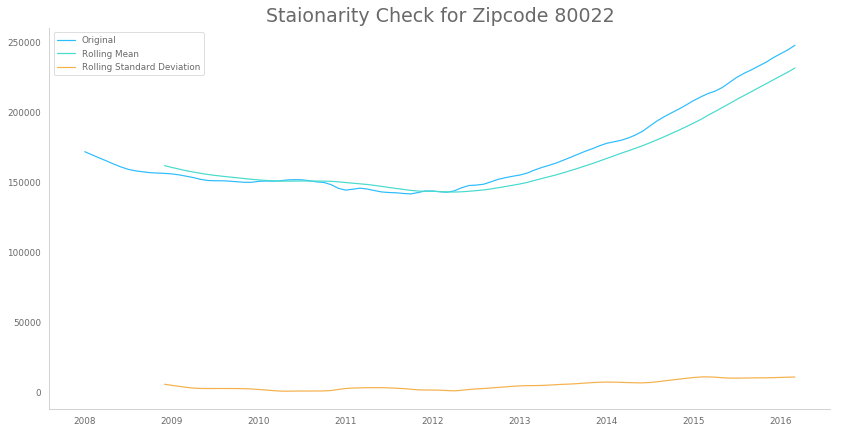

Results of Dickey-Fuller Test
Test Statistic                 -0.458943
p-value                         0.899783
#Lags Used                     11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


In [39]:
check_stationarity(adams_train[2], adams_zipcodes[2])

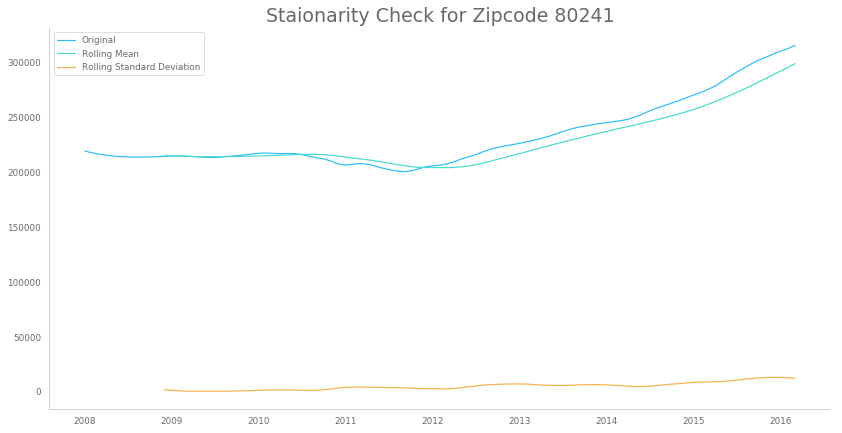

Results of Dickey-Fuller Test
Test Statistic                  0.843443
p-value                         0.992306
#Lags Used                      9.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


In [40]:
check_stationarity(adams_train[9],adams_zipcodes[9])

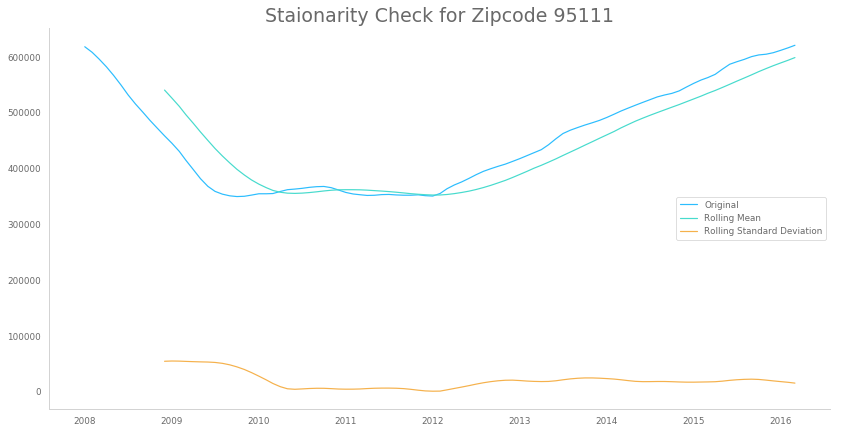

Results of Dickey-Fuller Test
Test Statistic                 -0.698201
p-value                         0.847215
#Lags Used                      4.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [41]:
check_stationarity(santa_clara_train[14], santa_clara_zipcodes[14])

None of the three zipcodes examined exhibit stationarity.
- In all cases the rolling mean exhibits a trend
- The Dickey-Fuller test cannot reject the null hypothesis of non-stationarity in any case

As such, we will make the assumption that the data is **not stationary**.  This means that the model selected will need to correct for non-stationarity.

## Step 8: Check for Seasonality

It is not possible to check seasonality in every zipcode.  Therefore, check for a random selection of 3, one from each county, will be checked.  An assumption will then be made about seasonality, and applied to the entire set of zipcodes.

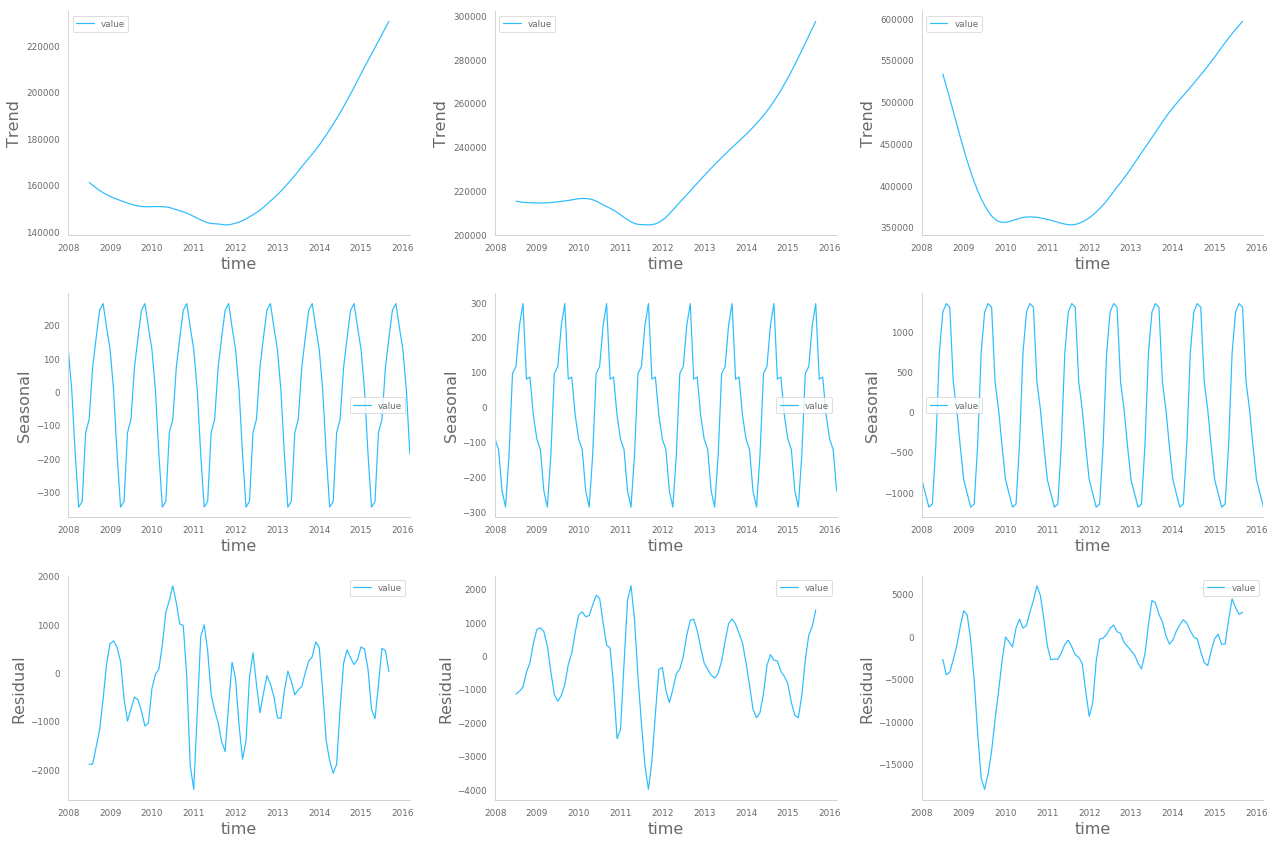

In [42]:
# Create 3X3 grid of plots, each column contains one zipcode, each row contains a trend, seasonal or white noise component
fig, axes = plt.subplots(3,3, figsize=(18,12))

# Apply check_seasonality() function to decompose the time series into a trend, seasonal and white noise component
check_seasonality(adams_train[2],0)

check_seasonality(adams_train[9],1)

check_seasonality(santa_clara_train[14],2)

fig.tight_layout()
plt.show()


As can be seen from the above, there appears to be an annual cycle in house prices.  This will need to be controlled for by the model selected.

# Step 9: Check for Autocorrelation/Partial-Autocorrelation

Plotting the autocorrelation and partial-autocorrelation functions for a time series helps us to understand the impact of the past house prices, on today's values.  In turn, this allows us to include lagged terms (dependent variables and error terms) in our models to improve predictive power.

Again, the autocorrelation and partial-autocorrelation functions for three random zipcodes (one from each county) is plotted.

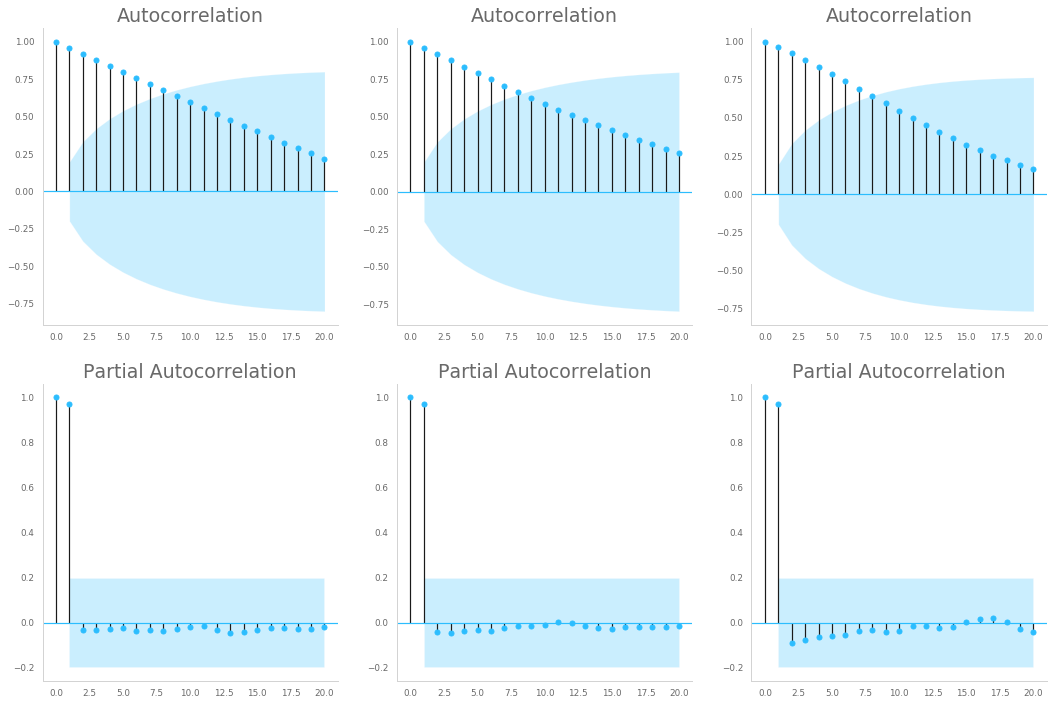

In [43]:
# Create a 2 X 3 figure to display the ACF and PACF
fig,ax = plt.subplots(2,3,figsize=(18,12))

# Run the check_autocorrelation() function, which plots the acf and pacf for a given dataset
check_autocorrelation(adams_train[2],20, 0)
check_autocorrelation(adams_train[9],20, 1)
check_autocorrelation(santa_clara_train[14],20, 2)

As can be seen from the autocorrelation plots above, around historic house prices for about 8 periods (months) seem to be important in determinging the value of houses today.  However, once the prior periods are controlled for, by the partial autocorrelation plot, this falls to 2 lagged periods.

We would therefore expect 2 lagged dependent variables and/or 2 lagged residuals to be necessary in our model.

# Step 10: ARIMA Modeling

### Calculate the Optimal p,d,q for ARIMA/SARIMA Model

Two alternative models will be compared for their relative performance:

- **ARIMA**: Corrects for non-stationarity by differencing by specified number of terms (d), includes lagged dependent variables (p) and lagged residuals (q) for specified number of periods
- **SARIMA**: As above, but also corrects for seasonality (s) within the data.

Given that the data has exhibited seasonality, we would expect the SARIMA model to offer the best performance.

Before estimating these models, the optimal p, d and q will be determined by running a SARIMA model for each zipcode and combination of p, d and q.  The values of p, d and q for the model with the best performance, as given by the lowest AIC, will be selected.  This is performed for all zipcodes in Santa Clara and Adams.

#### Adams, Colorado

In [44]:
# Create an empty list to contain the optimal order (p,d,q) and seasonal order (p,d,q,12)
optimal_order_adams = []
optimal_seasonal_order_adams = []

# For each zipcode, select the optimal order and append it to the relevant list
for i in range(0,len(adams_train)):
    
    optimal = optimise_sarimax(adams_train[i], 3,2,2)
    optimal.reset_index(inplace=True)
    
    order = literal_eval(optimal['pdq'][0])
    seasonal_order = literal_eval(optimal['pdqs'][0])
    
    optimal_order_adams.append(order)
    optimal_seasonal_order_adams.append(seasonal_order)
    

#### Santa Clara, California

In [45]:
# Create an empty list to contain the optimal order (p,d,q) and seasonal order (p,d,q,12)
optimal_order_santa_clara = []
optimal_seasonal_order_santa_clara = []

# For each zipcode, select the optimal order and append it to the relevant list
for i in range(0,len(santa_clara_train)):
    
    optimal = optimise_sarimax(santa_clara_train[i], 3,2,2)
    optimal.reset_index(inplace=True)
    
    order = literal_eval(optimal['pdq'][0])
    seasonal_order = literal_eval(optimal['pdqs'][0])
    
    optimal_order_santa_clara.append(order)
    optimal_seasonal_order_santa_clara.append(seasonal_order)
    

### ARIMA Model

It is now possible to run the ARIMA models for each zipcode.  This will first be done for Adams, and performance reviewed, to determine whether this approach provides a viable way forward.

In [46]:
# Create an empty list to contain the ARIMA model for each zipcode
adams_arima_models = []

# For each Adams zipcode, run the ARIMA model and append to list
for i in range(0, len(adams_train)):
    arima_model = sm.tsa.ARIMA(endog=adams_train[i], order = optimal_order_adams[i]).fit()
    adams_arima_models.append(arima_model)

Having estimated a set of ARIMA models for Adams, performance can be assessed by comparing the house prices, as predicted by the model, versus actual prices.  See charts for predicted v. actual house prices below.

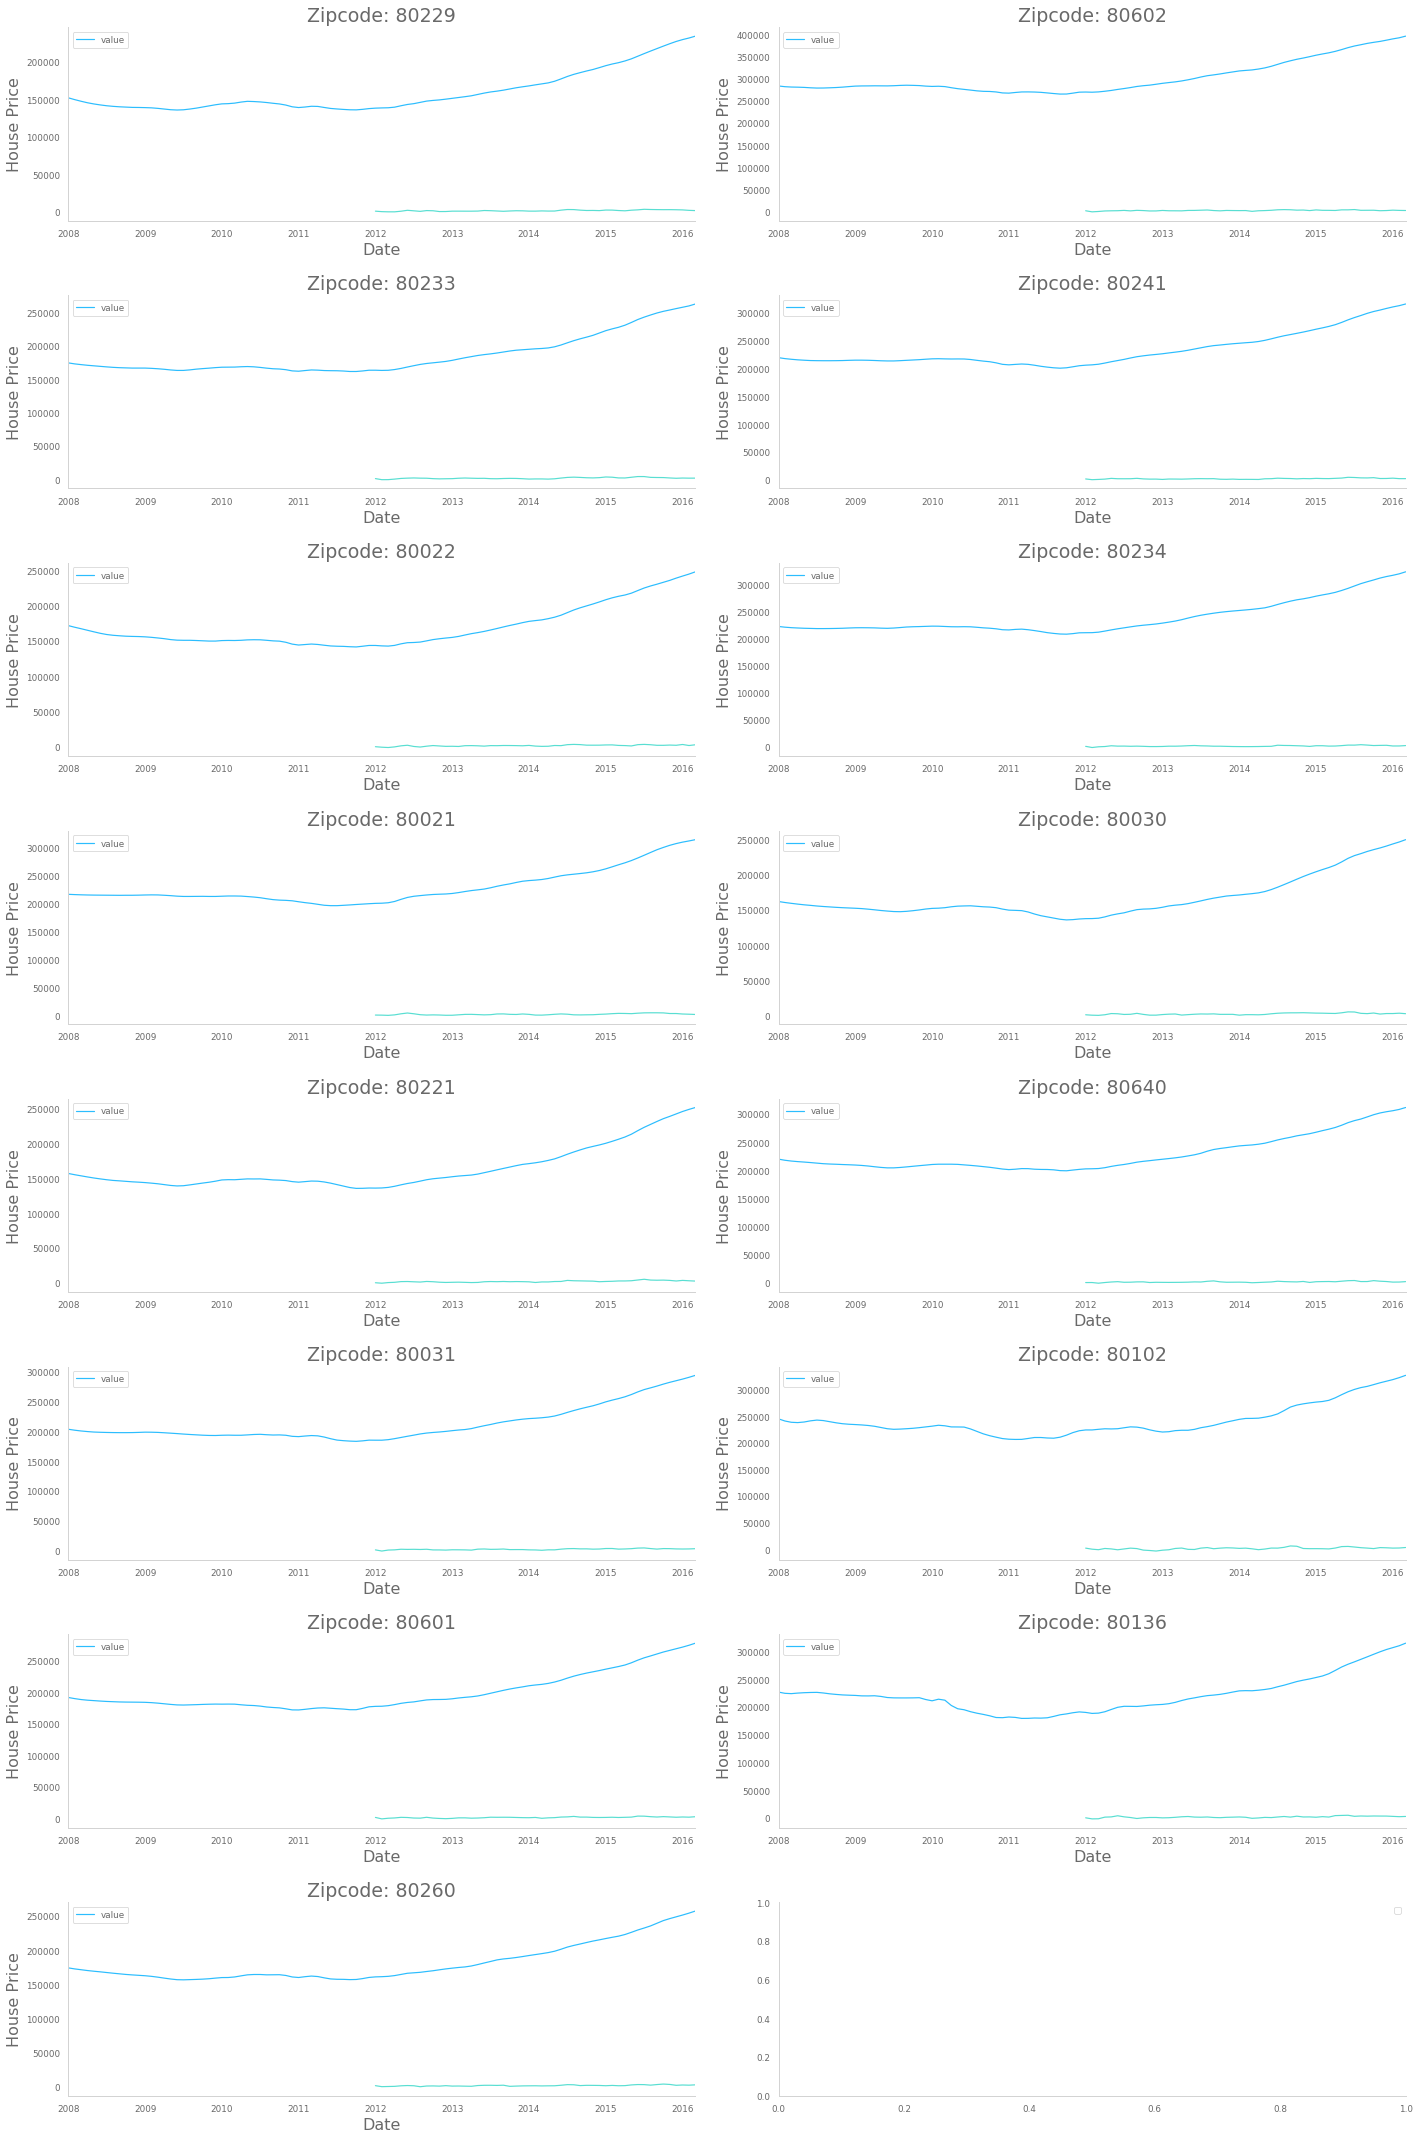

In [47]:
# Create a figure with 16 subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,30))

# For each zipcode:
for i in range(0,len(adams_train)):
    
    if i<= 7:
        col = 0
    else:
        col= 1
        
    row = i%8
    
    # Specify the subplot upon which the zipcode's predicted/actual values will sit
    ax=axes[row][col]
    
    # Generate the predictions for each zipcode (starting in 2012)
    pred = adams_arima_models[i].predict(start='2012-01-01', dynamic=False)

    # Plot actual v. predicted
    adams_train[i].plot(label='observed', ax=ax)
    pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
    
    # Set title, axis labels etc.
    ax.set_title(f"Zipcode: {adams_zipcodes[i]}")
    ax.set_xlabel('Date')
    ax.set_ylabel('House Price')
    plt.legend(['Observed', 'One-Step Ahead Forecast'])
    



plt.tight_layout()
plt.show()

It is clear from the above that the performance of the ARIMA model is very poor in this circumstance.  The ARIMA model significantlty underpredicts house prices in all cases.  This is likely due to the seasonality, which has not been corrected for. 

As such, we will proceed directly to estimation using the SARIMA model.

### SARIMA Model

Given that the optimal values of p,d and q have already been computed per zipcode, it is possible to continue with estimation of each SARIMA model.  This will be done for Adams and Santa Clara in turn.  Performance will thene be evaluated by visualising the actual v. predicted values for the training set, and calculating the RMSE.

#### Adams, Colorado

In [48]:
# Create an empty list to contain each SARIMA model
adams_sarima_models = []

# Run the SARIMA model for each Adams zipcode, append the model to the empty list
for i in range(0, len(adams_train)):
    model = sm.tsa.statespace.SARIMAX(endog=adams_train[i], order = optimal_order_adams[i], seasonal_order = optimal_seasonal_order_adams[i], enforce_stationarity = False, enforce_invertibility = False, freq='MS').fit()
    adams_sarima_models.append(model)   

To check that the residual meets the required assumptions of a random, normally distributed variable, the plot_diagnostics() function is run for a random model.  The 'Standardized residual' chart suggests that the residual is white noise, whilst the Q-Q plot/histogram indicates that it is approximately normally distributed.

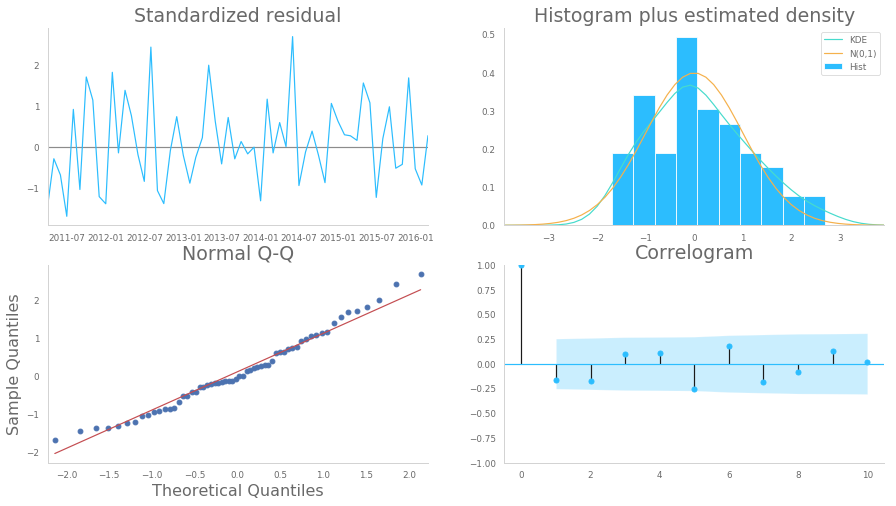

In [49]:
# Run the plot_diagnostics() function
adams_sarima_models[4].plot_diagnostics(figsize=(15,8))
plt.show()

Next, it is possible to visualise the actual house prices versus the predicted house prices for each zip code.

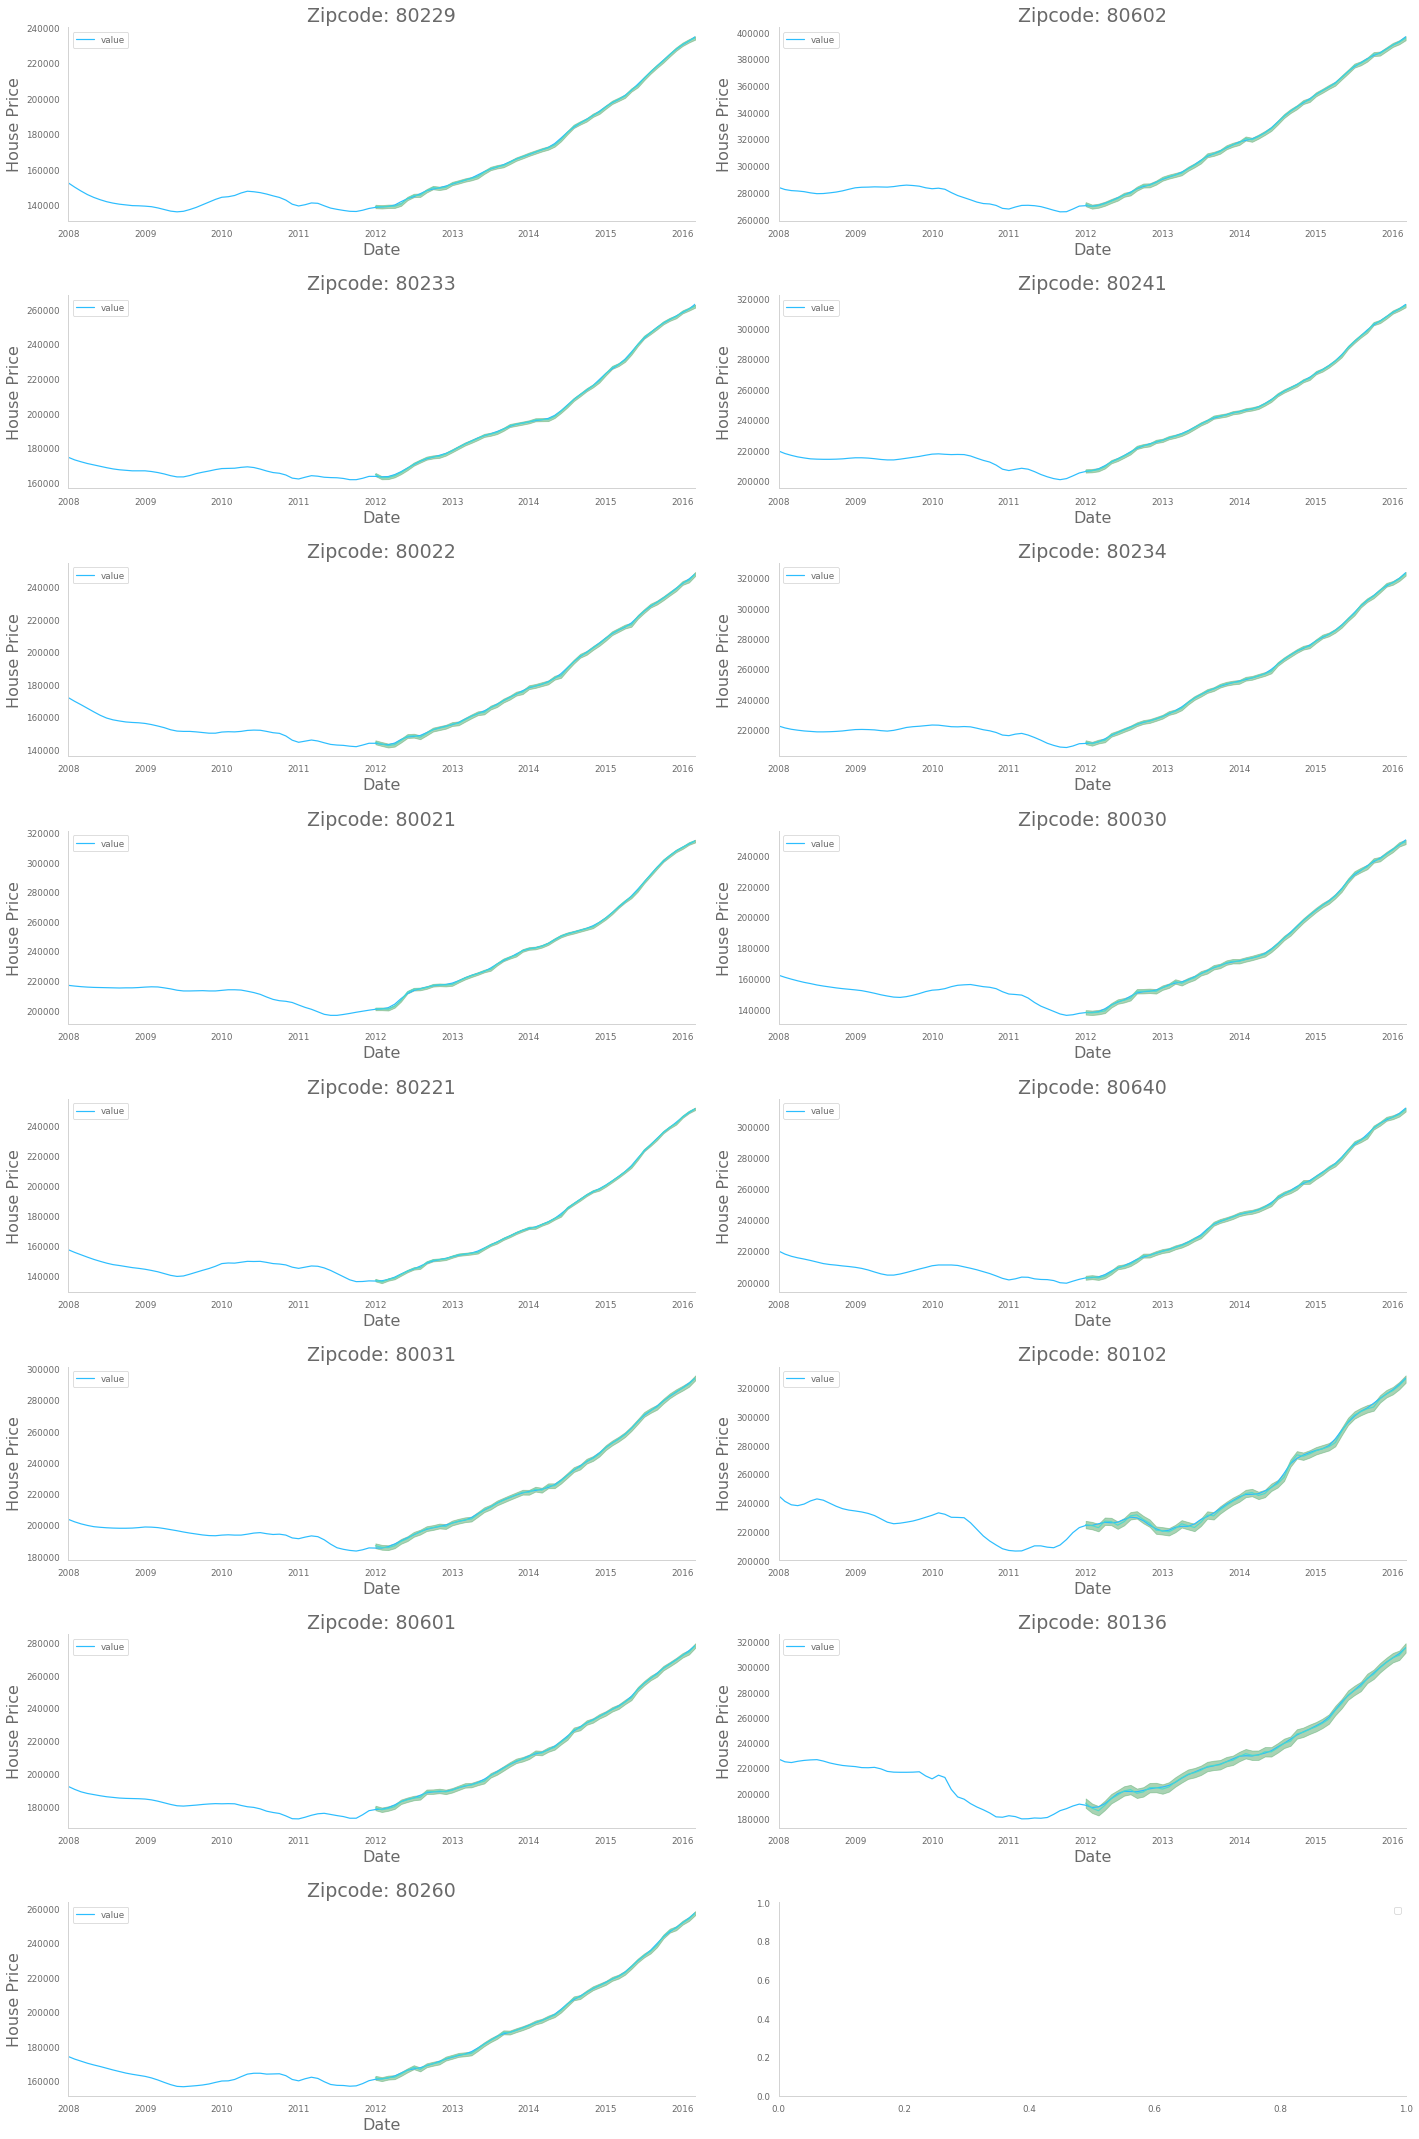

In [50]:
# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,30))

for i in range(0,len(adams_train)):
    
    if i<= 7:
        col = 0
    else:
        col= 1
        
    row = i%8
    
    # Specify the subplot upon which the zipcode's predicted/actual values will sit
    ax=axes[row][col]
    
    # Generate predictions for each zipcode, starting in 2012
    pred = adams_sarima_models[i].get_prediction(start='2012-01-01', dynamic=False)
    pred_conf = pred.conf_int()

    # Plot predicted v. actual values
    adams_train[i].plot(label='observed', ax=ax)
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)
    
    # Set title, axis labels etc
    ax.set_title(f"Zipcode: {adams_zipcodes[i]}")
    ax.set_xlabel('Date')
    ax.set_ylabel('House Price')
    plt.legend(['Observed', 'One-Step Ahead Forecast'])
    



plt.tight_layout()
plt.show()

Finally, the RMSE is calculated.  It is given as a % of April 2018 house prices to contextualise the degree of uncertainty.

In [51]:
adams_rmses = []

for i in range(0, len(adams_train)):
    pred = adams_sarima_models[i].get_prediction(start='2008-01-01', dynamic=False)
    predictions = pred.predicted_mean
    rmse = np.sqrt(mean_squared_error(predictions, adams_train[i]))
    adams_rmses.append({'Zipcode': adams_zipcodes[i], 'RMSE':round(rmse,0), 'RMSE as % of 2018 House Price': round(((rmse/adams_test[i]['2018-04']['value'][0])*100),2)})
    

In [52]:
adams_rmse_df = pd.DataFrame(adams_rmses)
adams_rmse_df.sort_values(by='RMSE as % of 2018 House Price', inplace=True)
adams_rmse_df

,RMSE,RMSE as % of 2018 House Price,Zipcode
0,20205.0,6.72,80229
4,21367.0,6.73,80221
11,21304.0,6.77,80030
2,22023.0,7.02,80022
7,22815.0,7.02,80260
6,24483.0,7.20,80601
1,23869.0,7.43,80233
5,27389.0,7.64,80031
12,28691.0,7.73,80640
9,29419.0,7.88,80241


As can be seen from the above, the RMSE associated with each model does not exceed 9% as a proportion of 2018 house price.  This is reasonable.

#### Santa Clara, California

The same procedure is followed for Santa Clara.

In [53]:
# Create an empty list to contain each SARIMA model
santa_clara_sarima_models = []

# Run the SARIMA model for each Santa Clara zipcode, append the model to the empty list
for i in range(0, len(santa_clara_train)):
    model = sm.tsa.statespace.SARIMAX(endog=santa_clara_train[i], order = optimal_order_santa_clara[i], seasonal_order = optimal_seasonal_order_adams[i], enforce_stationarity = False, enforce_invertibility = False, freq='MS').fit()
    santa_clara_sarima_models.append(model)   

Check the assumption of a random, normally distributed residual.  This appears to be satisfied.

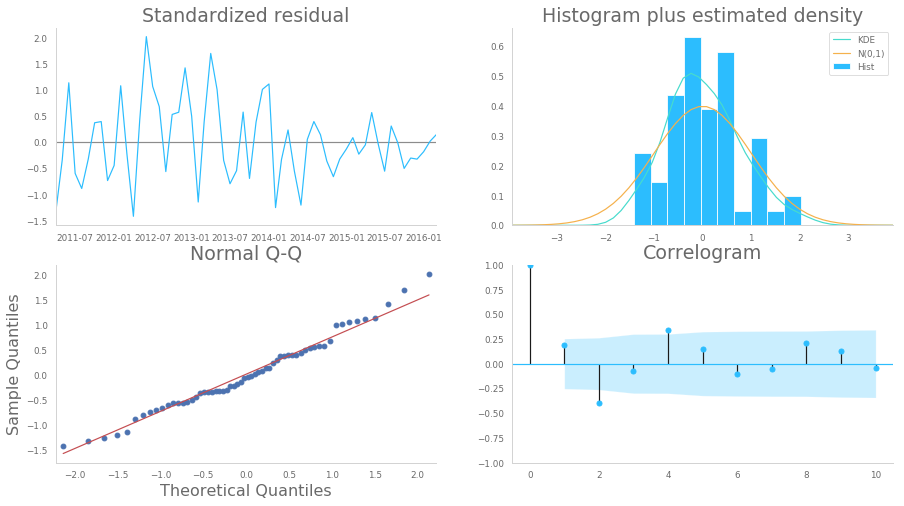

In [54]:
# Run the plot_diagnostics() function
santa_clara_sarima_models[9].plot_diagnostics(figsize=(15,8))
plt.show()

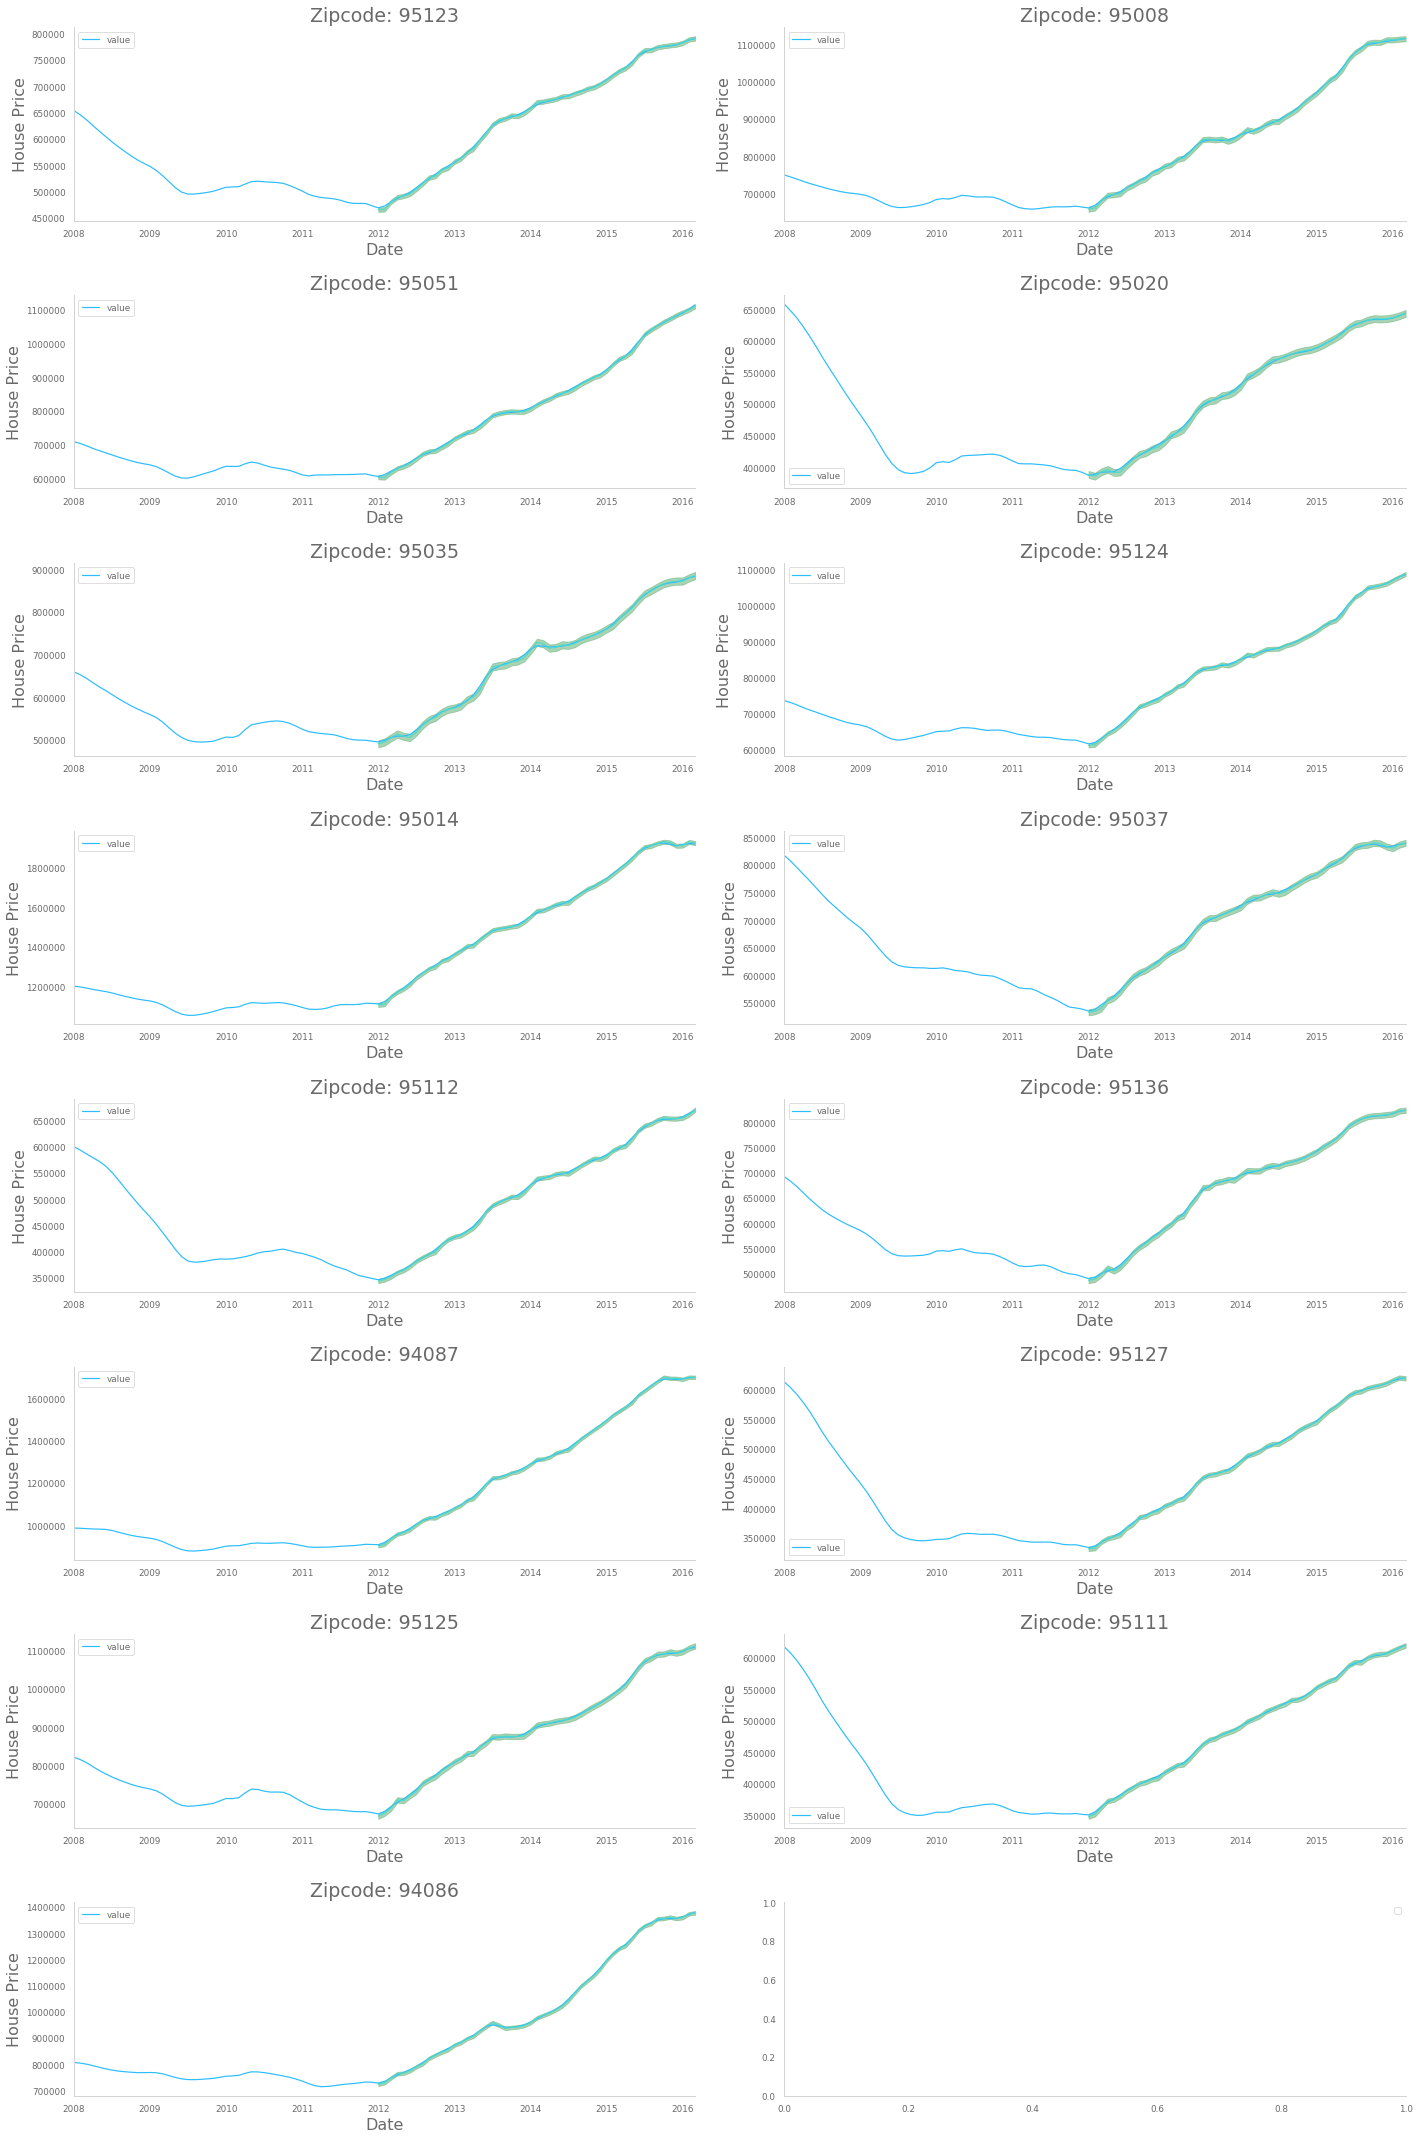

In [55]:
# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,30))

for i in range(0,len(santa_clara_train)):
    
    if i<= 7:
        col = 0
    else:
        col= 1
        
    row = i%8
    # Specify the subplot upon which the zipcode's predicted/actual values will sit
    ax=axes[row][col]
    
    # Generate predictiond and confidence intervals
    pred = santa_clara_sarima_models[i].get_prediction(start='2012-01-01', dynamic=False)
    pred_conf = pred.conf_int()

    # Plot predicted versus actual values
    santa_clara_train[i].plot(label='observed', ax=ax)
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

    # Plot confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)
    
    # Set title and axes labels
    ax.set_title(f"Zipcode: {santa_clara_zipcodes[i]}")
    ax.set_xlabel('Date')
    ax.set_ylabel('House Price')
    plt.legend(['Observed', 'One-Step Ahead Forecast'])
    



plt.tight_layout()
plt.show()

Calculate the RMSE as a percentage of 2018 house price.

In [56]:
santa_clara_rmses = []

for i in range(0, len(adams_train)):
    pred = santa_clara_sarima_models[i].get_prediction(start='2008-01-01', dynamic=False)
    predictions = pred.predicted_mean
    rmse = np.sqrt(mean_squared_error(predictions, santa_clara_train[i]))
    santa_clara_rmses.append({'Zipcode': santa_clara_zipcodes[i], 'RMSE':round(rmse,0), 'RMSE as % of 2018 House Price': round(((rmse/santa_clara_test[i]['2018-04']['value'][0])*100),2)})
    

In [57]:
santa_clara_rmse_df = pd.DataFrame(santa_clara_rmses)
santa_clara_rmse_df.sort_values(by='RMSE as % of 2018 House Price', inplace=True)
santa_clara_rmse_df

,RMSE,RMSE as % of 2018 House Price,Zipcode
1,94766.0,6.01,95051
7,133104.0,6.91,94086
5,158062.0,6.94,94087
8,114430.0,7.43,95008
10,114127.0,7.92,95124
2,96726.0,8.33,95035
3,209567.0,8.42,95014
6,130199.0,8.87,95125
0,95121.0,9.11,95123
4,86267.0,9.42,95112


The performance of the Santa Clara models vary between 6% and 12%.  It will be important to select zipcodes that have models with good performance, as well as high growth predictions.

## Step 11: Validate Model with Test Data

Having established that the models perform well against the data with which they were trained, they can then be measured against the test data.  This helps to ensure that the models have not been overtrained.

#### Adams, Colorado

In [58]:
adams_forecasts = []

for i in range(0, len(adams_test)):
    pred = adams_sarima_models[i].forecast(n-training_n)
    adams_forecasts.append(pred)

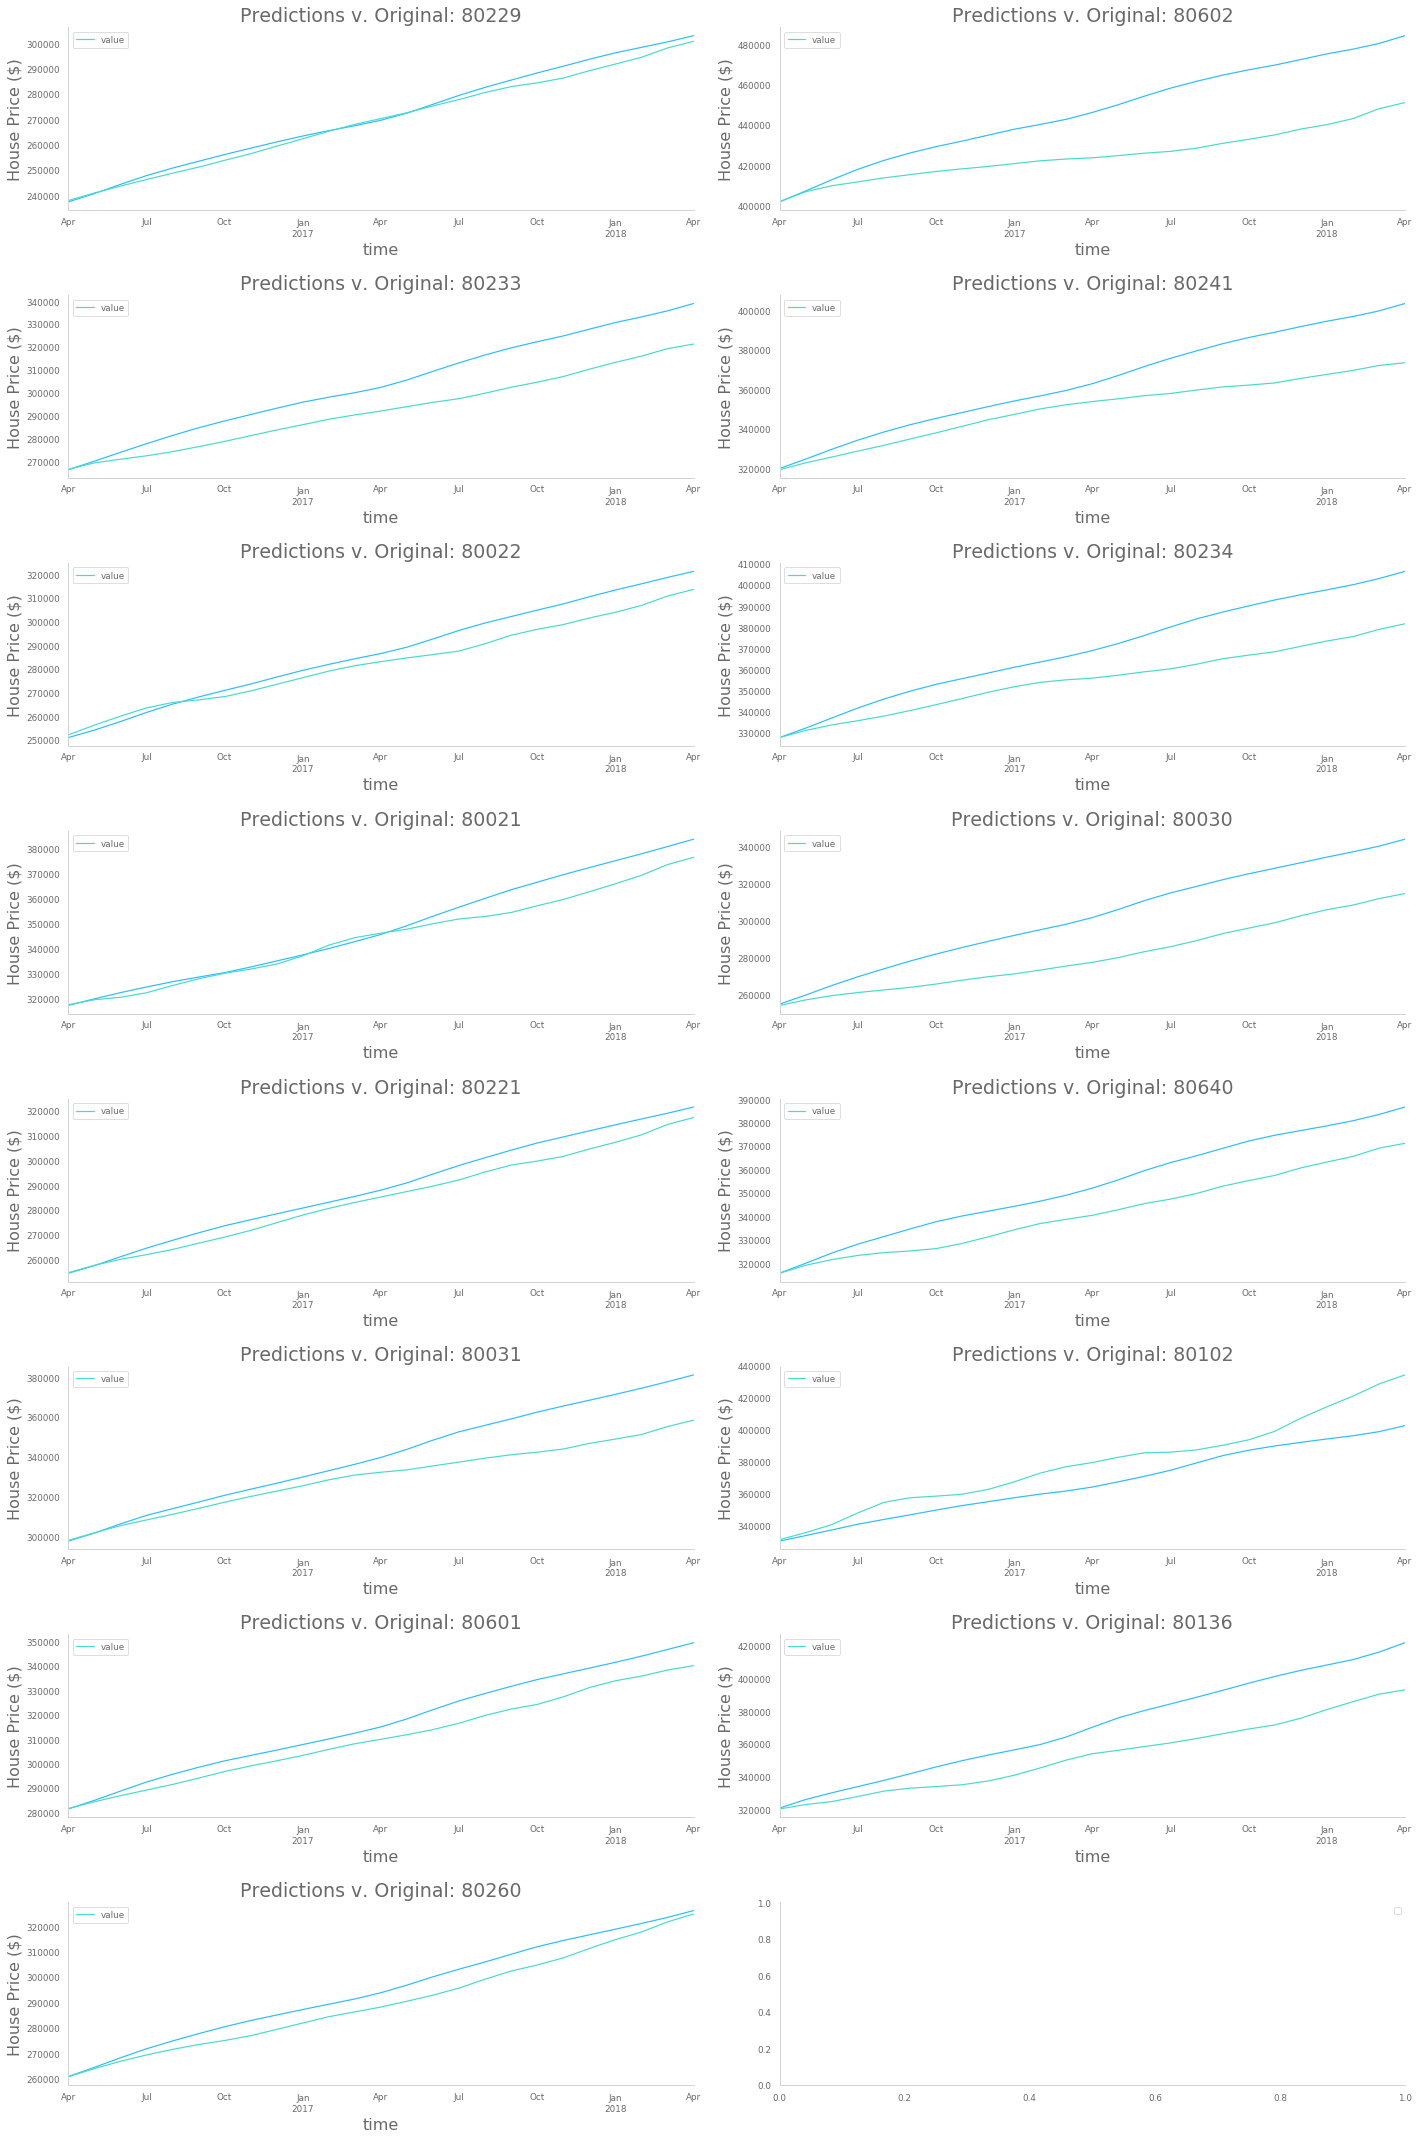

In [59]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,30))

for i in range(0,len(adams_train)):
    
    if i<= 7:
        col = 0
    else:
        col= 1
        
    row = i%8
    
    ax=axes[row][col]
    
    adams_forecasts[i].plot(label='Predicted', ax=ax)
    adams_test[i].plot(label='Original', ax=ax)
    
    ax.set_title(f"Predictions v. Original: {adams_zipcodes[i]}")
    ax.set_ylabel('House Price ($)')
    plt.legend(['Predicted', 'Original'])


plt.tight_layout()
plt.show()



In all cases, the predictions follow a very similar trend to the actual data.  

The RMSE is then calculated RMSE:

In [60]:
adams_rmses = []

for i in range(0, len(adams_test)):
    rmse = np.sqrt(mean_squared_error(adams_forecasts[i], adams_test[i]))
    adams_rmses.append({'Zipcode': adams_zipcodes[i], 'RMSE':round(rmse,0), 'RMSE as % of 2018 House Price': round(((rmse/adams_test[i]['2018-04']['value'][0])*100),2)})
    

In [61]:
adams_test_rmse_df = pd.DataFrame(adams_rmses)
adams_test_rmse_df.sort_values(by='RMSE as % of 2018 House Price', inplace=True)
adams_test_rmse_df

,RMSE,RMSE as % of 2018 House Price,Zipcode
0,2406.0,0.80,80229
3,5423.0,1.44,80021
4,4723.0,1.49,80221
7,5075.0,1.56,80260
2,5921.0,1.89,80022
6,6605.0,1.94,80601
13,14372.0,3.31,80102
12,12408.0,3.34,80640
5,13748.0,3.84,80031
1,12757.0,3.97,80233


Model performance when applied to the test data is as good/better than for the training data.  This suggests that the model has not been overfitted, and can be used to generate additional predictions into the future.

#### Santa Clara, California

The same procedure is followed for the Santa Clara data.

In [62]:
santa_clara_forecasts = []

for i in range(0, len(santa_clara_test)):
    pred = santa_clara_sarima_models[i].forecast(n-training_n)
    santa_clara_forecasts.append(pred)

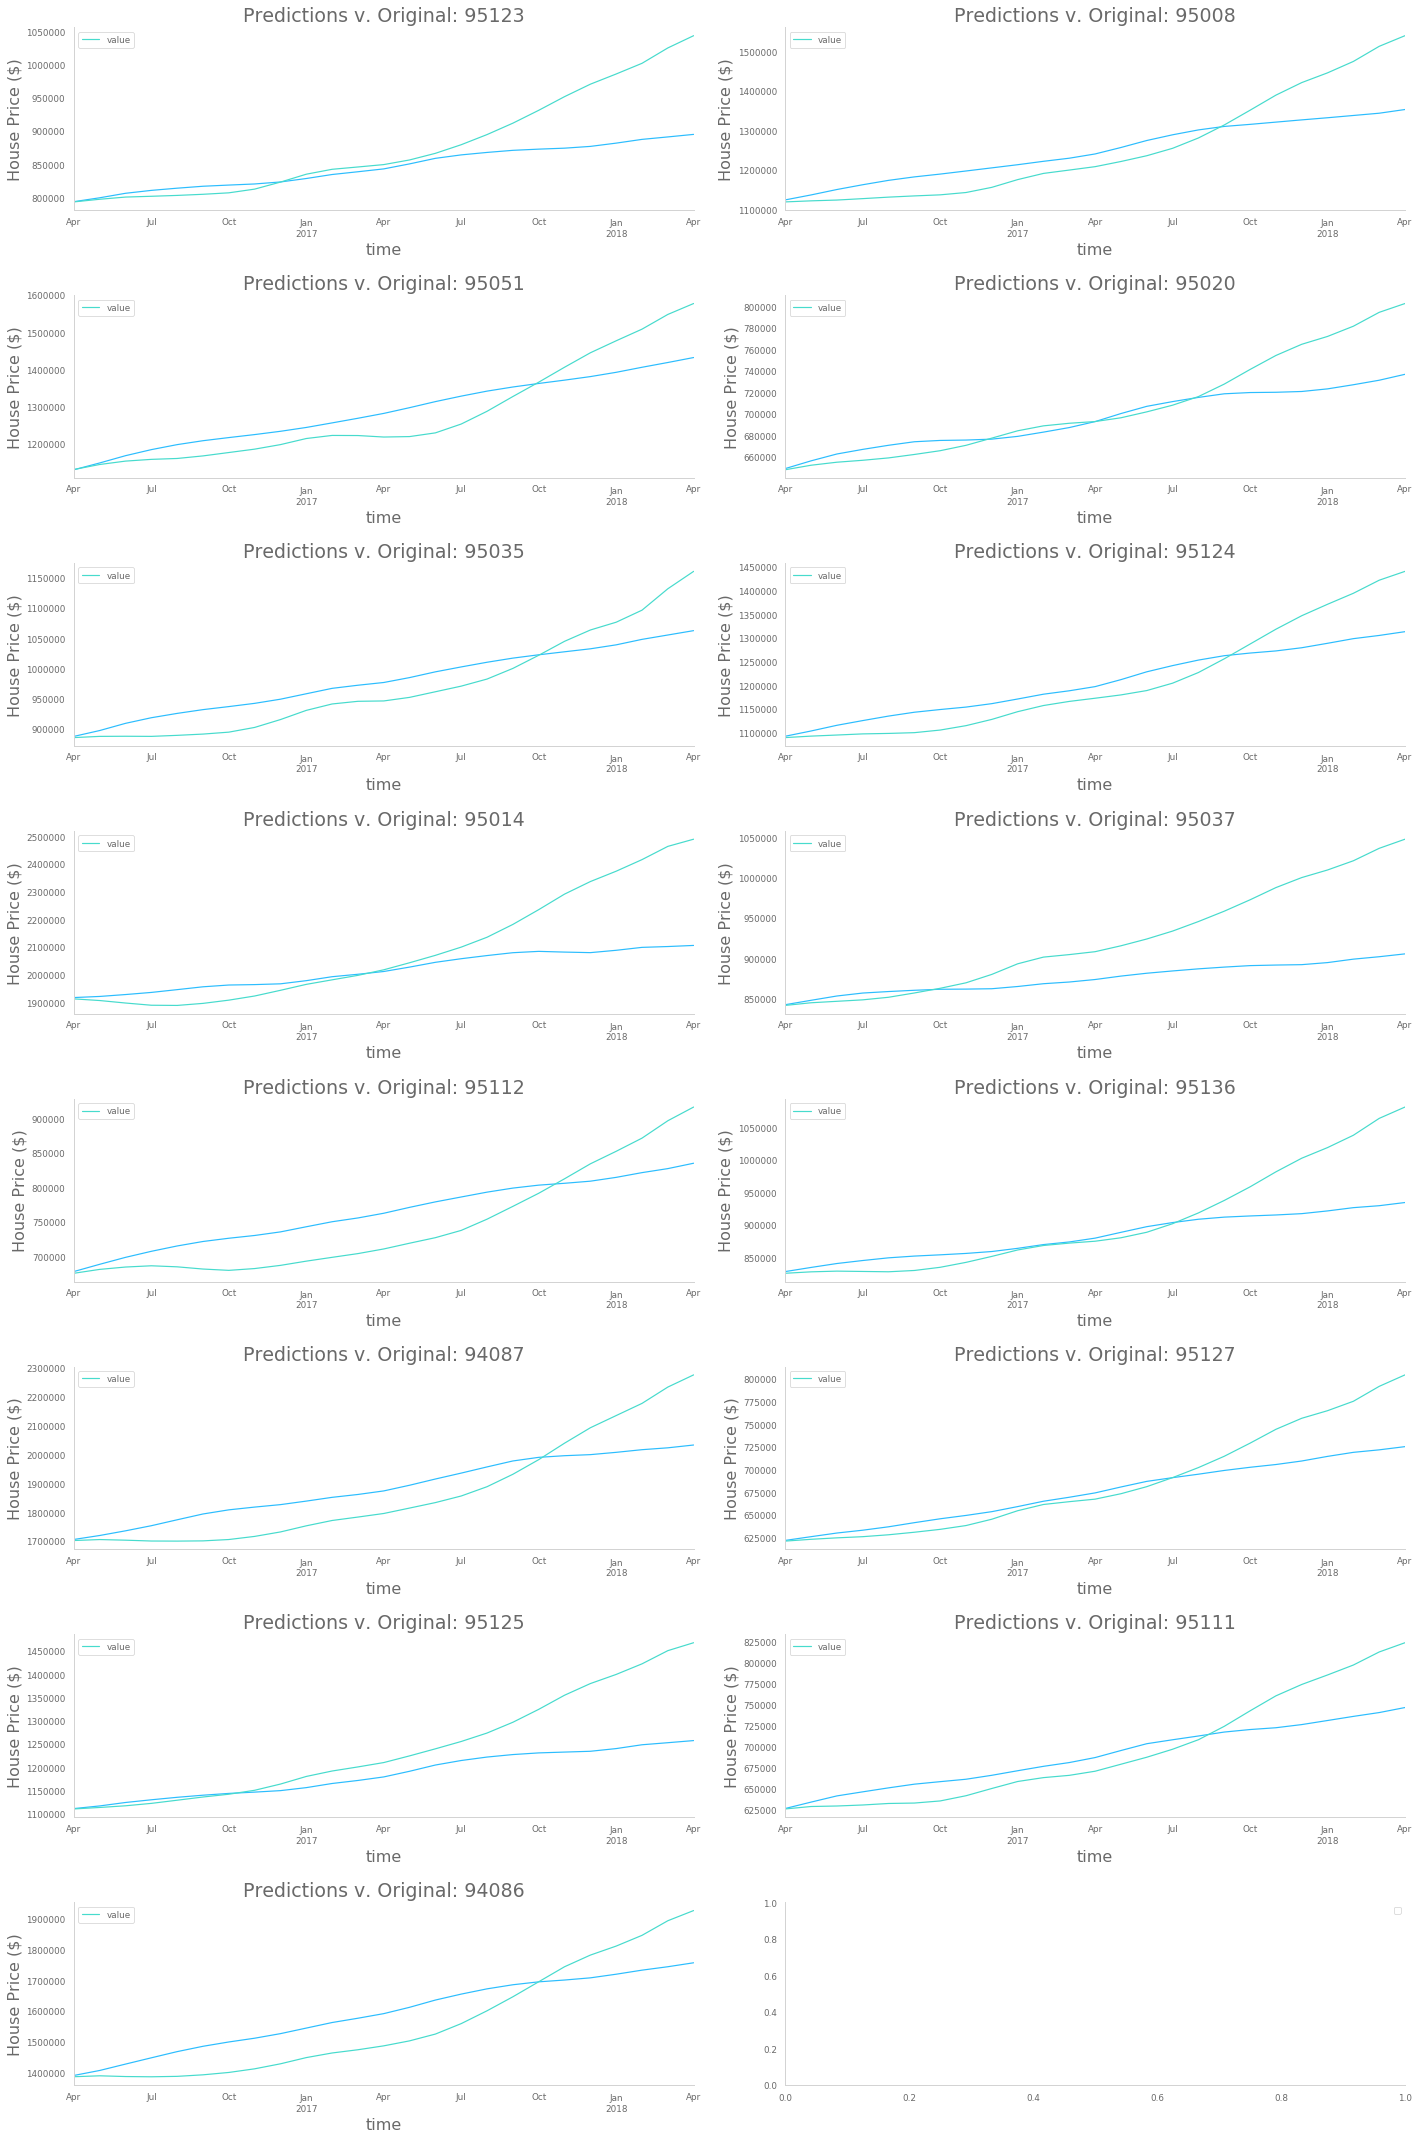

In [63]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20,30))

for i in range(0,len(santa_clara_train)):
    
    if i<= 7:
        col = 0
    else:
        col= 1
        
    row = i%8
    
    ax=axes[row][col]
    
    santa_clara_forecasts[i].plot(label='Predicted', ax=ax)
    santa_clara_test[i].plot(label='Original', ax=ax)
    
    ax.set_title(f"Predictions v. Original: {santa_clara_zipcodes[i]}")
    ax.set_ylabel('House Price ($)')
    plt.legend(['Predicted', 'Original'])


plt.tight_layout()
plt.show()

There appears to be a slight divergence in trend for the predictions versus the actual data.  To assess the implications of this, RMSE is calculated.

In [64]:
santa_clara_rmses = []

for i in range(0, len(santa_clara_test)):
    rmse = np.sqrt(mean_squared_error(santa_clara_forecasts[i], santa_clara_test[i]))
    santa_clara_rmses.append({'Zipcode': santa_clara_zipcodes[i], 'RMSE':round(rmse,0), 'RMSE as % of 2018 House Price': round(((rmse/santa_clara_test[i]['2018-04']['value'][0])*100),2)})

In [65]:
santa_clara_test_rmse_df = pd.DataFrame(santa_clara_rmses)
santa_clara_test_rmse_df.sort_values(by='RMSE as % of 2018 House Price', inplace=True)
santa_clara_test_rmse_df

,RMSE,RMSE as % of 2018 House Price,Zipcode
2,38317.0,3.30,95035
9,26819.0,3.34,95020
10,52532.0,3.65,95124
13,30016.0,3.73,95127
14,32191.0,3.91,95111
1,63223.0,4.01,95051
5,101300.0,4.45,94087
4,43043.0,4.70,95112
8,73063.0,4.74,95008
7,91711.0,4.76,94086


Again, performance when the models are applied to the test data seems to be as good/better than when applied to the training data.  This is a good indication that the models are fit for purpose.

## Step 12: Making Predictions

Finally, it is time to generate the predictions from 2018 to 2025.  These will provide Investate with the data they need to select 5 high potential postcodes.  This is done first for Adams, and then Colorado.

#### Adams, Colorado

In [66]:
# Create empty list to hold forecasts for each zipcode
adams_forecasts_2018_to_2025 = []

for i in range(0, len(adams_test)):
    pred = adams_sarima_models[i].predict(start=124, end=208)
    adams_forecasts_2018_to_2025.append(pred)
    

In [67]:
# Calculate % growth from 2020 to 2025 for each zipcode
adams_growth_forecast_2020_to_2025 = []
for i in range(0, len(adams_test)):
    growth = ((adams_forecasts_2018_to_2025[i]['2025-05-01'] - adams_forecasts_2018_to_2025[i]['2020-05-01'])/adams_forecasts_2018_to_2025[i]['2020-05-01'])*100
    adams_growth_forecast_2020_to_2025.append({'Zipcode': adams_zipcodes[i], 'Growth2020to2025': round(growth,0)})
    

In [68]:
# Create a dataframe containing the growth rate for each zipcode
adams_growth_df = pd.DataFrame(adams_growth_forecast_2020_to_2025)
adams_growth_df.sort_values(by=['Growth2020to2025'], ascending=False, inplace=True)

To visualise the performance of each zipcode, a map will be used to display growth versus model performance (risk).  Before creating this map, the latitude and longitude for each zipcode is required.  These have been sourced, and placed in a file 'denver_zipcodes.csv'.

In [69]:
# Import denver zipcodes file as DataFrame
adams_zipcodes_df = pd.read_csv('denver_zipcodes.csv', header=1)
adams_zipcodes_df.drop(['Unnamed: 3', 'Unnamed: 4','Unnamed: 5','Unnamed: 6'], axis=1, inplace=True)

In [70]:
# Join adams_zipcodes_df and adams_growth_df to create master dataframe
adams_growth_df = adams_growth_df.set_index('Zipcode').join(adams_zipcodes_df.set_index('Zipcode'), lsuffix='l')
adams_growth_df = adams_growth_df.join(adams_test_rmse_df.set_index('Zipcode'), lsuffix='r')
adams_growth_df.sort_values(by=['Growth2020to2025'], ascending=True, inplace=True)
adams_growth_df.reset_index(inplace=True)
adams_growth_df.reset_index(inplace=True)

The resulting dataframe, sorted by growth rate, shows that the zipcode with the highest forecast growth (80030), also has the poorest model performance (7.34% RMSE as a % of 2018 house price).  

In [71]:
adams_growth_df

,index,Zipcode,Growth2020to2025,Latitude,Longitude,RMSE,RMSE as % of 2018 House Price
0,0,80602,35.0,39.966363,-104.908709,24693.0,5.47
1,1,80640,38.0,39.887453,-104.880987,12408.0,3.34
2,2,80021,39.0,39.890663,-105.113724,5423.0,1.44
3,3,80234,39.0,39.909992,-105.002643,16664.0,4.37
4,4,80102,40.0,39.745990,-104.442841,14372.0,3.31
5,5,80601,41.0,39.962027,-104.807809,6605.0,1.94
6,6,80260,41.0,39.866918,-105.006059,5075.0,1.56
7,7,80221,42.0,39.817067,-105.011035,4723.0,1.49
8,8,80241,42.0,39.929518,-104.954808,16820.0,4.50
9,9,80233,44.0,39.899671,-104.946561,12757.0,3.97


To assist with selection of the best postcodes, the 2020-25 growth is visualised on a map, alongside RMSE as a % of 2018 house price.  

In [72]:
# Make an empty map
adams_map = folium.Map(location=[39.9, -105], zoom_start=11)

for i in range(0,len(adams_growth_df)):
    folium.Circle(
           location=[adams_growth_df.iloc[i]['Latitude'], adams_growth_df.iloc[i]['Longitude']],
           popup=adams_growth_df.iloc[i]['Zipcode'],
           radius=adams_growth_df.iloc[i]['index']*140,
           color='#39ff14',
           fill=True,
           fill_color='green'
       ).add_to(adams_map)
        
    folium.Circle(
           location=[adams_growth_df.iloc[i]['Latitude'], adams_growth_df.iloc[i]['Longitude']],
           popup=adams_growth_df.iloc[i]['Zipcode'],
           radius=adams_growth_df.iloc[i]['RMSE as % of 2018 House Price']*140,
           color='red',
           fill=True,
           fill_color='red'
       ).add_to(adams_map)

adams_map

To interpret the map, higher levels of growth are associated with larger green circles, meanwhile, lower levels of RMSE as % of house price are associated with smaller red circles.  We're therefore looking for zipcodes that provide high growth (large green circle) alongside excellent model performance (small red circles).  From the above, the following zipcodes appear to meet this criteria:
- 80229
- 80031
- 80022

#### Santa Clara, California

The same procedure is completed for the Santa Clara data.

In [73]:
santa_clara_forecasts_2018_to_2025 = []

for i in range(0, len(santa_clara_test)):
    pred = santa_clara_sarima_models[i].predict(start=124, end=208)
    santa_clara_forecasts_2018_to_2025.append(pred)
    

In [74]:
santa_clara_growth_forecast_2020_to_2025 = []
for i in range(0, len(santa_clara_test)):
    growth = ((santa_clara_forecasts_2018_to_2025[i]['2025-05-01'] - santa_clara_forecasts_2018_to_2025[i]['2020-05-01'])/santa_clara_forecasts_2018_to_2025[i]['2020-05-01'])*100
    santa_clara_growth_forecast_2020_to_2025.append({'Zipcode': santa_clara_zipcodes[i], 'Growth2020to2025': round(growth,0)})
    

In [75]:
santa_clara_growth_df = pd.DataFrame(santa_clara_growth_forecast_2020_to_2025)
santa_clara_growth_df.sort_values(by=['Growth2020to2025'], ascending=False, inplace=True)

In [76]:
santa_clara_zipcodes_df = pd.read_csv('california_zipcodes.csv')

In [77]:
santa_clara_growth_df = santa_clara_growth_df.set_index('Zipcode').join(santa_clara_zipcodes_df.set_index('Zipcode'), lsuffix='l')
santa_clara_growth_df = santa_clara_growth_df.join(santa_clara_test_rmse_df.set_index('Zipcode'), rsuffix='r')
santa_clara_growth_df.sort_values(by=['Growth2020to2025'], ascending=True, inplace=True)
santa_clara_growth_df.reset_index(inplace=True)
santa_clara_growth_df.reset_index(inplace=True)

In [78]:
santa_clara_growth_df

,index,Zipcode,Growth2020to2025,Latitude,Longitude,RMSE,RMSE as % of 2018 House Price
0,0,95037,14.0,37.137595,-121.66211,66970.0,6.39
1,1,95014,20.0,37.317909,-122.04779,158476.0,6.36
2,2,95123,26.0,37.244426,-121.83246,58670.0,5.62
3,3,95125,26.0,37.295092,-121.89649,89367.0,6.09
4,4,95020,26.0,37.016943,-121.56581,26819.0,3.34
5,5,95136,26.0,37.269343,-121.84939,56018.0,5.18
6,6,95127,31.0,37.369473,-121.82077,30016.0,3.73
7,7,94087,34.0,37.350091,-122.03602,101300.0,4.45
8,8,95111,34.0,37.284042,-121.82664,32191.0,3.91
9,9,95035,35.0,37.436451,-121.89438,38317.0,3.30


In [79]:
# Make an empty map
santa_clara_map = folium.Map(location=[37.4, -122], zoom_start=11)

for i in range(0,len(santa_clara_growth_df)):
    folium.Circle(
           location=[santa_clara_growth_df.iloc[i]['Latitude'], santa_clara_growth_df.iloc[i]['Longitude']],
           popup=santa_clara_growth_df.iloc[i]['Zipcode'],
           radius=santa_clara_growth_df.iloc[i]['index']*140,
           color='#39ff14',
           fill=True,
           fill_color='green'
       ).add_to(santa_clara_map)
        
    folium.Circle(
           location=[santa_clara_growth_df.iloc[i]['Latitude'], santa_clara_growth_df.iloc[i]['Longitude']],
           popup=santa_clara_growth_df.iloc[i]['Zipcode'],
           radius=santa_clara_growth_df.iloc[i]['RMSE as % of 2018 House Price']*140,
           color='red',
           fill=True,
           fill_color='red'
       ).add_to(santa_clara_map)

santa_clara_map

In general, model performance is not as good as the Colorado models.  However, the following zip codes offer high potential.
- 95051
- 94086

## Step 13: Interpreting Results

Based on the analysis above, the following recommendations are made:
- To create a diverse portfolio and minimise risk, investments should be made in two geographically distinct states: Colorado and California
- Within these states, we recommend focussing on residential acquisitions within the counties of Adams (Colorado) and Santa Clara (California).  Both areas offer good growth potential.
- Our models have shown that the following zipcodes offer good returns (over 35% across a 5 year period) according to a robust forecasting model (RMSE as a % of 2018 house price < 5%):
    - 80229
    - 80031
    - 80022
    - 95051
    - 94086

The charts below illustrates expected house price performance across the period within each zipcode.  As can be seen, the value of houses in California is much higher than Colorado.  This further diversifies the investment portfolio.

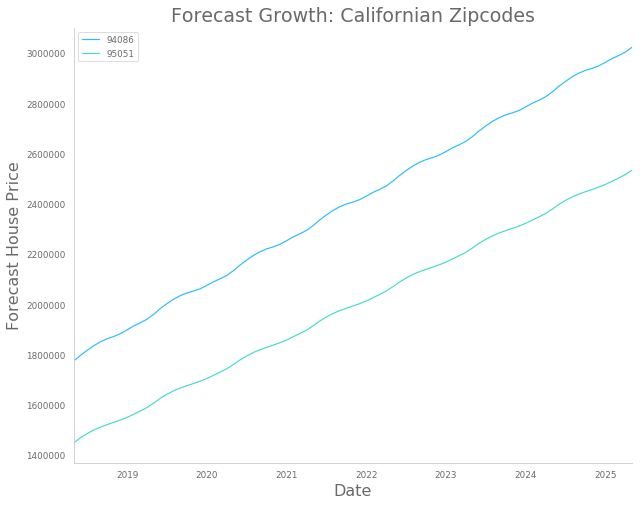

In [80]:
plt.figure(figsize=(10,8))
ax = santa_clara_forecasts_2018_to_2025[7].plot(label='94086')
santa_clara_forecasts_2018_to_2025[1].plot(ax=ax, label='95051')
plt.title('Forecast Growth: Californian Zipcodes')
plt.xlabel('Date')
plt.ylabel('Forecast House Price')
plt.legend()
plt.show()

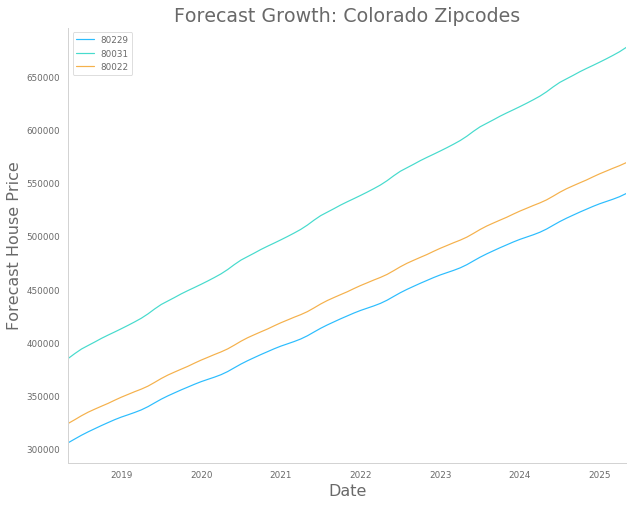

In [81]:
plt.figure(figsize=(10,8))
ax = adams_forecasts_2018_to_2025[0].plot(label='80229')
adams_forecasts_2018_to_2025[5].plot(ax=ax, label='80031')
adams_forecasts_2018_to_2025[2].plot(ax=ax, label='80022')
plt.title('Forecast Growth: Colorado Zipcodes')
plt.xlabel('Date')
plt.ylabel('Forecast House Price')
plt.legend()
plt.show()

## Step 14: Recommendations

- Invest in two geographically distinct areas: California & Colorado
- Create a diverse portfolio by investing in property at multiple price points within these 5 zip codes
    - 94086: 3 million USD
    - 95051: 2.5 million USD
    - 80229: 0.5 million USD
    - 80031: 0.6 million USD
    - 80022: 0.6 million USD

- Let properties to receive ongoing income over term of investment:
    - Santa Clara: 3.7K USD per month
    - Adams: 2.0K USD per month

- Sell properties around 2025 with expected return of 40-45%.

## Step 15: Future Work

- Investigate type of property in which to invest (e.g. number of bedrooms, size etc.)
- Confirm performance of models against real data